# LSTM Setup

In [6]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import dateutil.parser
import matplotlib.pyplot as plt


class BalancedDataLoaderIterator:
    '''
    This class iterates over multiple PyTorch dataloaders in a balanced way, 
    ensuring that all dataloaders contribute to the training equally. 
    It uses random sampling to choose from multiple dataloaders while 
    handling different dataset lengths.
    '''
    def __init__(self, dataloaders):
        self.dataloaders = dataloaders

        self.num_dataloaders = len(dataloaders)

        max_length = max(len(dataloader) for dataloader in dataloaders)

        length_list = [len(dataloader) for dataloader in dataloaders]
        print("data loader length:", length_list)
        print("max dataloader length:", max_length,
              "epoch iteration:", max_length * self.num_dataloaders)
        self.total_length = max_length * self.num_dataloaders
        self.current_iteration = 0
        self.probabilities = torch.ones(
            self.num_dataloaders, dtype=torch.float) / self.num_dataloaders

    def __iter__(self):
        self.iterators = [iter(dataloader) for dataloader in self.dataloaders]
        self.current_iteration = 0
        return self

    def __next__(self):
        if self.current_iteration >= self.total_length:
            raise StopIteration

        chosen_index = torch.multinomial(self.probabilities, 1).item()
        try:
            sample = next(self.iterators[chosen_index])
        except StopIteration:
            self.iterators[chosen_index] = iter(self.dataloaders[chosen_index])
            sample = next(self.iterators[chosen_index])

        self.current_iteration += 1
        return sample, chosen_index

    def __len__(self):
        return self.total_length

In [7]:


# --------------------------- #
#        Data Preprocessing   #
# --------------------------- #
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import dateutil.parser

def load_all_sites_balanced(
    base_dir='../processed_ds/air_quality_cluster/', 
    window_size=32, 
    horizon=16, 
    batch_size=16,
    min_date=None, 
    max_date=None,
    device="cpu"
):
    """
    Loads and preprocesses time series data for all sites, ensuring balanced training across sites.

    Args:
    - base_dir (str): Path to the directory containing site folders.
    - window_size (int): Number of past time steps for input.
    - horizon (int): Number of future steps to predict.
    - batch_size (int): Batch size for DataLoader.
    - min_date (str or datetime, optional): Start date for filtering data.
    - max_date (str or datetime, optional): End date for filtering data.

    Returns:
    - balanced_train_loader: Balanced DataLoader across all sites for training.
    - site_val_loaders: Dictionary of validation DataLoaders per site.
    - site_test_loaders: Dictionary of test DataLoaders per site.
    """
    
    # Get the list of site directories
    site_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    site_dirs.sort()

    train_loaders = []
    site_val_loaders = {}
    site_test_loaders = {}

    for site in site_dirs:
        site_path = os.path.join(base_dir, site)
        csv_files = [f for f in os.listdir(site_path) if f.endswith('.csv')]
        csv_files.sort()

        for csv_file in csv_files:
            file_path = os.path.join(site_path, csv_file)
            df_site = pd.read_csv(file_path)

            # Convert date column to datetime if it exists
            if 'date' in df_site.columns:
                df_site['date'] = pd.to_datetime(df_site['date'])

                # Filter based on min_date and max_date
                if min_date:
                    min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
                    df_site = df_site[df_site['date'] >= min_date]

                if max_date:
                    max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
                    df_site = df_site[df_site['date'] <= max_date]

                # Drop date column after filtering
                df_site.drop(columns=['date'], inplace=True)

            # Perform 80-20 train-test split
            train_size = int(0.8 * len(df_site))
            train_df = df_site.iloc[:train_size]
            test_df = df_site.iloc[train_size:]

            # Split train_df further into Train (80%) and Validation (20%)
            val_size = int(0.2 * len(train_df))  # 16% of full dataset
            train_df, val_df = train_df.iloc[:-val_size], train_df.iloc[-val_size:]

            print(f"Site: {site} | Train: {len(train_df)} | Validation: {len(val_df)} | Test: {len(test_df)}")

            # Standardize data per site (avoid data leakage)
            train_mean, train_std = train_df.mean(), train_df.std()
            train_df = (train_df - train_mean) / (train_std + 1e-8)
            val_df = (val_df - train_mean) / (train_std + 1e-8)
            test_df = (test_df - train_mean) / (train_std + 1e-8)

            # Convert DataFrame to NumPy arrays for LSTM
            X_train, y_train = df_to_X_y(train_df, window_size, horizon)
            X_val, y_val = df_to_X_y(val_df, window_size, horizon)
            X_test, y_test = df_to_X_y(test_df, window_size, horizon)

            # Convert to PyTorch tensors
            # train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
            # val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
            # test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
            
            train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
            val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
            test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

            # Create DataLoaders
            train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
            val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
            test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

            # Store loaders for this site
            train_loaders.append(train_loader)
            site_val_loaders[site] = val_loader
            site_test_loaders[site] = test_loader

    # Create Balanced DataLoader for Training
    balanced_train_loader = BalancedDataLoaderIterator(train_loaders)

    return balanced_train_loader, site_val_loaders, site_test_loaders

def load_all_sites_data(
    base_dir='../processed_ds/air_quality_cluster/', 
    window_size=32, 
    horizon=16, 
    batch_size=16,
    min_date=None, 
    max_date=None
):
    """
    Loads and preprocesses time series data for all sites in a directory.

    Args:
    - base_dir (str): Path to the directory containing site folders.
    - window_size (int): Number of past time steps for input.
    - horizon (int): Number of future steps to predict.
    - batch_size (int): Batch size for DataLoader.
    - min_date (str or datetime, optional): Start date for filtering data.
    - max_date (str or datetime, optional): End date for filtering data.

    Returns:
    - train_loader, val_loader, test_loader: DataLoaders for training, validation, and testing.
    """
    
    # Get the list of site directories
    site_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    site_dirs.sort()

    train_dfs, val_dfs, test_dfs = [], [], []

    for site in site_dirs:
        site_path = os.path.join(base_dir, site)
        csv_files = [f for f in os.listdir(site_path) if f.endswith('.csv')]
        csv_files.sort()

        for csv_file in csv_files:
            file_path = os.path.join(site_path, csv_file)
            df_site = pd.read_csv(file_path)

            # Convert date column to datetime if it exists
            if 'date' in df_site.columns:
                df_site['date'] = pd.to_datetime(df_site['date'])

                # Filter based on min_date and max_date
                if min_date:
                    min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
                    df_site = df_site[df_site['date'] >= min_date]

                if max_date:
                    max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
                    df_site = df_site[df_site['date'] <= max_date]

                # Drop date column after filtering
                df_site.drop(columns=['date'], inplace=True)

            # # Add a site identifier column
            # df_site['site'] = int(site.split('-')[1])

            # Perform 80-20 train-test split
            train_size = int(0.8 * len(df_site))
            train_df = df_site.iloc[:train_size]
            test_df = df_site.iloc[train_size:]

            # Split train_df further into Train (80%) and Validation (20%)
            val_size = int(0.2 * len(train_df))  # 16% of full dataset
            train_df, val_df = train_df.iloc[:-val_size], train_df.iloc[-val_size:]

            # Store separate train, val, and test sets
            train_dfs.append(train_df)
            val_dfs.append(val_df)
            test_dfs.append(test_df)

    # Concatenate all site data for train, validation, and test
    train_df = pd.concat(train_dfs, ignore_index=True)
    val_df = pd.concat(val_dfs, ignore_index=True)
    test_df = pd.concat(test_dfs, ignore_index=True)

    print(f"Total Train Size: {len(train_df)} | Validation Size: {len(val_df)} | Test Size: {len(test_df)}")

    # Standardize the data using only train statistics
    train_mean, train_std = train_df.mean(), train_df.std()
    train_df = (train_df - train_mean) / (train_std + 1e-8)
    val_df = (val_df - train_mean) / (train_std + 1e-8)  # Normalize validation using train stats
    test_df = (test_df - train_mean) / (train_std + 1e-8)  # Normalize test using train stats

    # Convert DataFrame to NumPy arrays for LSTM
    X_train, y_train = df_to_X_y(train_df, window_size, horizon)
    X_val, y_val = df_to_X_y(val_df, window_size, horizon)
    X_test, y_test = df_to_X_y(test_df, window_size, horizon)

    # Convert to PyTorch tensors
    train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
    test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

    # Create DataLoaders
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

    return train_loader, val_loader, test_loader


def load_and_preprocess_site_data(site_path, window_size=32, horizon=16, min_date=None, max_date=None, batch_size=16, device='cpu'):
    """
    Loads and preprocesses time series data for a given site.

    Args:
    - site_path (str): Path to the site CSV file.
    - window_size (int): Number of past time steps for input.
    - horizon (int): Number of future steps to predict.

    Returns:
    - train_loader, val_loader, test_loader: DataLoaders for training, validation, and testing.
    """
    df = pd.read_csv(site_path)
    
    # Convert date column to datetime if it exists
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

        # Filter data between min_date and max_date
        if min_date:
            min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
            df = df[df['date'] >= min_date]

        if max_date:
            max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
            df = df[df['date'] <= max_date]

        # Drop the date column after filtering
        df.drop(columns=['date'], inplace=True)
        
    
    # Perform an 80-20 split based on time order
    train_size = int(0.8 * len(df))
    train_df = df.iloc[:train_size]  # 80% for training & validation
    test_df = df.iloc[train_size:]   # 20% for final testing (future unseen data)

    # Split train_df further into Train (80%) and Validation (20%)
    val_size = int(0.2 * len(train_df))  # 16% of full dataset
    train_df, val_df = train_df.iloc[:-val_size], train_df.iloc[-val_size:]

    print(f"Train size: {len(train_df)} | Validation size: {len(val_df)} | Test size: {len(test_df)}")

    # Standardize each separately to prevent data leakage
    train_mean, train_std = train_df.mean(), train_df.std()
    
    train_df = (train_df - train_mean) / (train_std + 1e-8)
    val_df = (val_df - train_mean) / (train_std + 1e-8)  # Normalize validation using train stats
    test_df = (test_df - train_mean) / (train_std + 1e-8)  # Normalize test using train stats

    # Convert DataFrame to NumPy arrays for LSTM
    X_train, y_train = df_to_X_y(train_df,window_size, horizon)
    X_val, y_val = df_to_X_y(val_df, window_size, horizon)
    X_test, y_test = df_to_X_y(test_df, window_size, horizon)

    # Convert to PyTorch tensors
    # train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    # val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
    # test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
    
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
    val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
    test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

    # Create DataLoaders
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

    return train_loader, val_loader, test_loader

def load_all_sites_data_independent_tests(
    base_dir='../processed_ds/air_quality_cluster/', 
    window_size=32, 
    horizon=16, 
    batch_size=16,
    min_date=None, 
    max_date=None,
    device='cpu'
):
    """
    Loads and preprocesses time series data for all sites in a directory.
    Ensures that test sets are NOT concatenated (kept independent per site).

    Args:
    - base_dir (str): Path to the directory containing site folders.
    - window_size (int): Number of past time steps for input.
    - horizon (int): Number of future steps to predict.
    - batch_size (int): Batch size for DataLoader.
    - min_date (str or datetime, optional): Start date for filtering data.
    - max_date (str or datetime, optional): End date for filtering data.

    Returns:
    - train_loader (DataLoader): DataLoader for training.
    - val_loader (DataLoader): DataLoader for validation.
    - test_loaders (dict): Dictionary of DataLoaders for testing per site.
    """
    
    import dateutil.parser
    
    # Get the list of site directories
    site_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    site_dirs.sort()

    train_dfs, val_dfs = [], []
    test_loaders = {}  # Dictionary to store independent test loaders for each site

    for site in site_dirs:
        site_path = os.path.join(base_dir, site)
        csv_files = [f for f in os.listdir(site_path) if f.endswith('.csv')]
        csv_files.sort()

        for csv_file in csv_files:
            file_path = os.path.join(site_path, csv_file)
            df_site = pd.read_csv(file_path)

            # Convert date column to datetime if it exists
            if 'date' in df_site.columns:
                print("Date found... Filtering now...")
                df_site['date'] = pd.to_datetime(df_site['date'])

                # Filter based on min_date and max_date
                if min_date:
                    min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
                    df_site = df_site[df_site['date'] >= min_date]

                if max_date:
                    max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
                    df_site = df_site[df_site['date'] <= max_date]

                # Drop date column after filtering
                df_site.drop(columns=['date'], inplace=True)

            # Perform 80-20 train-test split
            train_size = int(0.8 * len(df_site))
            train_df = df_site.iloc[:train_size]
            test_df = df_site.iloc[train_size:]

            # Split train_df further into Train (80%) and Validation (20%)
            val_size = int(0.2 * len(train_df))  # 16% of full dataset
            train_df, val_df = train_df.iloc[:-val_size], train_df.iloc[-val_size:]

            # Store separate train and validation sets
            train_dfs.append(train_df)
            val_dfs.append(val_df)

            # Standardize test_df using training statistics
            train_mean, train_std = train_df.mean(), train_df.std()
            test_df = (test_df - train_mean) / (train_std + 1e-8)  # Normalize test using train stats

            # Convert test set to tensors
            X_test, y_test = df_to_X_y(test_df, window_size, horizon)
            test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))
            test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

            # Store test_loader in dictionary with site name
            test_loaders[site] = test_loader

    # Concatenate all site data for train and validation
    train_df = pd.concat(train_dfs, ignore_index=True)
    val_df = pd.concat(val_dfs, ignore_index=True)

    print(f"Total Train Size: {len(train_df)} | Validation Size: {len(val_df)} | Test Sites: {len(test_loaders)}")

    # Standardize the training and validation data using only train statistics
    train_mean, train_std = train_df.mean(), train_df.std()
    train_df = (train_df - train_mean) / (train_std + 1e-8)
    val_df = (val_df - train_mean) / (train_std + 1e-8)  # Normalize validation using train stats

    # Convert DataFrame to NumPy arrays for LSTM
    X_train, y_train = df_to_X_y(train_df, window_size, horizon)
    X_val, y_val = df_to_X_y(val_df, window_size, horizon)

    # Convert to PyTorch tensors
    # train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    # val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
    
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
    val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
    # Create DataLoaders
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)

    return train_loader, val_loader, test_loaders

def load_and_preprocess_site_data_arimax(site_path, target='OT', features=None, min_date=None, max_date=None):
    """
    Loads and preprocesses time series data for ARIMAX modeling.

    Args:
        site_path (str): Path to the site's CSV file.
        target (str): Name of the target column (default 'OT').
        features (list or None): List of feature column names. If None, use all columns in the CSV.
        min_date (str or datetime, optional): Minimum date to include.
        max_date (str or datetime, optional): Maximum date to include.

    Returns:
        train_endog, train_exog, test_endog, test_exog:
            - train_endog: pandas Series for the training target.
            - train_exog: pandas DataFrame for the training exogenous regressors.
            - test_endog: pandas Series for the test target.
            - test_exog: pandas DataFrame for the test exogenous regressors.
    """
    # Load CSV data
    df = pd.read_csv(site_path)
    
    # If no feature list is provided, use all columns
    if features is None:
        features = df.columns.tolist()
    
    # Ensure target is included in the features
    if target not in features:
        features.append(target)
    
    # Convert 'date' column to datetime if present and filter by provided dates
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        if min_date:
            min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
            df = df[df['date'] >= min_date]
        if max_date:
            max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
            df = df[df['date'] <= max_date]
        # Drop the date column after filtering
        df.drop(columns=['date'], inplace=True)
        df.reset_index(inplace=True)
    
    # Filter dataframe to only include the specified features
    features = [col for col in features if col.lower() != 'date']
    df = df[features]
    
    # Split the data into training (80%) and test (20%) sets based on time order
    train_size = int(0.8 * len(df))
    train_df = df.iloc[:train_size].copy()
    test_df = df.iloc[train_size:].copy()
    
    print(f"Train size: {len(train_df)} | Test size: {len(test_df)}")
    
    # Compute scaling factors using only the training data to prevent data leakage
    train_mean, train_std = train_df.mean(), train_df.std()
    train_df = (train_df - train_mean) / (train_std + 1e-8)
    test_df  = (test_df - train_mean) / (train_std + 1e-8)
    
    # Define exogenous features as all features except the target
    exog_features = [col for col in features if col != target]
    
    # Extract target and exogenous regressors for each split
    train_endog = train_df[target]
    train_exog  = train_df[exog_features]
    
    test_endog = test_df[target]
    test_exog  = test_df[exog_features]
    # print(train_endog.shape, train_exog.shape, test_endog.shape, test_exog.shape)    
    return train_endog, train_exog, test_endog, test_exog


def load_all_sites_data_arimax_population(
    base_dir='../processed_ds/air_quality_cluster/', 
    target='OT',
    features=None,
    min_date=None,
    max_date=None
):
    """
    Loads and preprocesses time series data for ARIMAX modeling from multiple sites.
    All training data from each site are concatenated into a single training set,
    while test data are kept separate per site.
    
    Args:
        base_dir (str): Directory containing site sub-folders (each with CSV files).
        target (str): Name of the target column.
        features (list or None): List of feature names. If None, all columns in the CSV are used.
        min_date (str or datetime, optional): Minimum date filter.
        max_date (str or datetime, optional): Maximum date filter.
        
    Returns:
        train_endog (Series): Concatenated training target series.
        train_exog (DataFrame): Concatenated training exogenous regressors.
        test_dict (dict): Dictionary where each key is a site name and the value is a tuple:
                          (test_endog, test_exog) for that site.
    """
    train_dfs = []  # List to collect training DataFrames from all sites
    test_data = {}  # Dictionary to store test DataFrame for each site

    # Get list of site directories
    site_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    site_dirs.sort()

    for site in site_dirs:
        site_path = os.path.join(base_dir, site)
        # Assume each site folder contains at least one CSV file.
        csv_files = [f for f in os.listdir(site_path) if f.endswith('.csv')]
        csv_files.sort()
        if not csv_files:
            continue
        
        # For simplicity, load the first CSV file for each site.
        file_path = os.path.join(site_path, csv_files[0])
        df_site = pd.read_csv(file_path)

        # Process the date column if it exists
        if 'date' in df_site.columns:
            df_site['date'] = pd.to_datetime(df_site['date'])
            if min_date:
                min_date = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
                df_site = df_site[df_site['date'] >= min_date]
            if max_date:
                max_date = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
                df_site = df_site[df_site['date'] <= max_date]
            # Drop the date column and reset index
            df_site.drop(columns=['date'], inplace=True)
            df_site.reset_index(drop=True, inplace=True)

        # If no features list is provided, use all columns.
        if features is None:
            features = df_site.columns.tolist()
        # Ensure target is included.
        if target not in features:
            features.append(target)
        # Remove any column named "date" (if somehow present)
        features = [col for col in features if col.lower() != 'date']
        df_site = df_site[features]

        # Split into train (80%) and test (20%) based on time order.
        train_size = int(0.8 * len(df_site))
        train_df = df_site.iloc[:train_size].copy()
        test_df = df_site.iloc[train_size:].copy()

        # Append training data
        train_dfs.append(train_df)
        # Save test data in dictionary under the site key.
        test_data[site] = test_df

    # Concatenate training data across all sites.
    train_df_concat = pd.concat(train_dfs, ignore_index=True)
    print(f"Total Training Samples: {len(train_df_concat)} | Number of Test Sites: {len(test_data)}")

    # Standardize using training data statistics
    train_mean = train_df_concat.mean()
    train_std = train_df_concat.std()
    train_df_std = (train_df_concat - train_mean) / (train_std + 1e-8)

    # Define exogenous features as all features except the target.
    exog_features = [col for col in features if col != target]
    train_endog = train_df_std[target]
    train_exog = train_df_std[exog_features]

    # Process test data: standardize each site's test set using training stats.
    test_dict = {}
    for site, test_df in test_data.items():
        test_df_std = (test_df - train_mean) / (train_std + 1e-8)
        test_endog = test_df_std[target]
        test_exog = test_df_std[exog_features]
        test_dict[site] = (test_endog, test_exog)

    return train_endog, train_exog, test_dict

def load_all_sites_data_arimax_concat_balanced(
    base_dir='../processed_ds/air_quality_cluster/', 
    target='OT',
    features=None,
    min_date=None,
    max_date=None,
    sample_size=None  # new parameter: number of samples to take from each site's training data
):
    """
    Loads and preprocesses time series data for ARIMAX modeling from multiple sites.
    All training data from each site are concatenated into a single training set (optionally
    using balanced sampling if sample_size is provided), while test data is kept separate.
    
    Args:
        base_dir (str): Directory containing site folders.
        target (str): Name of the target column.
        features (list or None): List of feature names. If None, use all columns.
        min_date (str or datetime, optional): Minimum date filter.
        max_date (str or datetime, optional): Maximum date filter.
        sample_size (int, optional): Number of training samples to randomly sample from each site.
        
    Returns:
        train_endog (pd.Series): Concatenated training target series.
        train_exog (pd.DataFrame): Concatenated training exogenous regressors.
        test_dict (dict): Dictionary mapping site names to a tuple (test_endog, test_exog).
    """
    train_dfs = []   # list to collect training DataFrames
    test_dict = {}   # dictionary to store test DataFrame for each site

    site_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    site_dirs.sort()

    for site in site_dirs:
        site_path = os.path.join(base_dir, site)
        csv_files = [f for f in os.listdir(site_path) if f.endswith('.csv')]
        csv_files.sort()
        if not csv_files:
            continue

        file_path = os.path.join(site_path, csv_files[0])
        df_site = pd.read_csv(file_path)

        # Process date column if exists.
        if 'date' in df_site.columns:
            df_site['date'] = pd.to_datetime(df_site['date'])
            if min_date:
                min_date_parsed = dateutil.parser.parse(min_date) if isinstance(min_date, str) else min_date
                df_site = df_site[df_site['date'] >= min_date_parsed]
            if max_date:
                max_date_parsed = dateutil.parser.parse(max_date) if isinstance(max_date, str) else max_date
                df_site = df_site[df_site['date'] <= max_date_parsed]
            df_site.drop(columns=['date'], inplace=True)
        
        # If no features provided, use all columns.
        if features is None:
            features = df_site.columns.tolist()
        if target not in features:
            features.append(target)
        features = [col for col in features if col.lower() != 'date']
        df_site = df_site[features]

        # Split into train (80%) and test (20%)
        train_size = int(0.8 * len(df_site))
        train_df = df_site.iloc[:train_size].copy()
        test_df = df_site.iloc[train_size:].copy()

        # Optionally perform balanced sampling on the training data.
        if sample_size is not None:
            if len(train_df) > sample_size:
                train_df = train_df.sample(n=sample_size, random_state=42)
        
        train_dfs.append(train_df)
        test_dict[site] = test_df

    train_df_concat = pd.concat(train_dfs, ignore_index=True)
    print(f"Total Training Samples: {len(train_df_concat)} | Number of Test Sites: {len(test_dict)}")

    # Standardize using training data statistics.
    train_mean = train_df_concat.mean()
    train_std = train_df_concat.std()
    train_df_std = (train_df_concat - train_mean) / (train_std + 1e-8)

    exog_features = [col for col in features if col != target]
    train_endog = train_df_std[target]
    train_exog = train_df_std[exog_features]

    for site, test_df in test_dict.items():
        test_df_std = (test_df - train_mean) / (train_std + 1e-8)
        test_endog = test_df_std[target]
        test_exog = test_df_std[exog_features]
        test_dict[site] = (test_endog, test_exog)

    return train_endog, train_exog, test_dict

def df_to_X_y(df, window_size=32, horizon=16):
    """
    Converts a DataFrame into supervised learning format for LSTM.

    Args:
    - df (pd.DataFrame): DataFrame containing time series.
    - window_size (int): Past window size.
    - horizon (int): Number of future steps.

    Returns:
    - X (np.array): Features.
    - y (np.array): Targets.
    """
    if "OT" not in df.columns:
        raise ValueError("The target column 'OT' is missing from the DataFrame.")

    df_as_np = df.to_numpy()
    target_col_idx = df.columns.get_loc("OT")  # Get the index of 'OT' column

    X, y = [], []

    for i in range(len(df_as_np) - window_size - horizon + 1):
        X.append(df_as_np[i:i + window_size])  # Past 'window_size' rows as features
        y.append(df_as_np[i + window_size:i + window_size + horizon, target_col_idx])  # Next 'horizon' steps for target

    return np.array(X), np.array(y)



# --------------------------- #
#          LSTM Model         #
# --------------------------- #

class LSTMModel(nn.Module):
    def __init__(self, num_features, time_window, output_window, num_labels, num_layers=2, hidden_size=16, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.output_window = output_window
        self.num_labels = num_labels

        self.lstm = nn.LSTM(num_features,
                            hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, num_labels * output_window)

    def forward(self, x):
        B, T, D = x.shape  
        x_, _ = self.lstm(x)
        last_hidden = x_[:, -1, :]  # Take last time step's hidden state
        x_ = self.fc(last_hidden)
        x_ = x_.reshape(B, self.output_window, self.num_labels)
        return x_


# --------------------------- #
#      Training Function      #
# --------------------------- #

def train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-3, wd=1e-5):
    """
    Trains an LSTM model with validation.

    Args:
    - model (nn.Module): The LSTM model.
    - train_loader (DataLoader): DataLoader for training.
    - val_loader (DataLoader): DataLoader for validation.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate.

    Returns:
    - None
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=wd)
    device = "cuda"

    model.to(device)
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # print(f"\nEPOCH {epoch+1}")
        
        # -------------------- Training -------------------- #
        model.train()
        running_train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            output = model(batch_x)
            loss = criterion(output, batch_y.unsqueeze(-1))  # Ensure correct shape
            running_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = running_train_loss / len(train_loader)
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # -------------------- Validation -------------------- #
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():  # Disable gradient calculations
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                output = model(batch_x)
                loss = criterion(output, batch_y.unsqueeze(-1))  # Ensure correct shape
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)


        # Print losses for the epoch
        # print(f"Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

    print("Training complete!")
     # -------------------- Plot Loss Curves -------------------- #

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses



# --------------------------- #
#      Evaluation Function    #
# --------------------------- #

def evaluate_model(model, test_loader):
    """
    Evaluates the LSTM model on test data.

    Args:
    - model (nn.Module): Trained LSTM model.
    - test_loader (DataLoader): DataLoader for testing.

    Returns:
    - mean_mae (float): Mean Absolute Error.
    """
    model.eval()
    criterion = nn.L1Loss()
    mae_list = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
            predictions = model(batch_x)
            mae = criterion(predictions, batch_y.unsqueeze(-1)).item()
            mae_list.append(mae)

    return np.mean(mae_list)



# -------------------------------------#
#      Balanced Training Function      #
# -------------------------------------#
def train_model_balanced(model, balanced_train_loader, site_val_loaders, num_epochs=30, lr=1e-3, wd=1e-5):
    """
    Trains an LSTM model using a balanced data loader (across multiple sites) and evaluates on
    separate site-specific validation loaders to prevent data leakage.

    Args:
      model (nn.Module): The LSTM model.
      balanced_train_loader (BalancedDataLoaderIterator): Iterator that yields (batch, chosen_index)
            from a list of site-specific training DataLoaders.
      site_val_loaders (dict): A dictionary mapping site identifiers to validation DataLoaders.
      num_epochs (int): Number of training epochs.
      lr (float): Learning rate.
      wd (float): Weight decay.
      
    Returns:
      train_losses (list): Average training loss per epoch.
      val_losses (list): Average validation loss per epoch (aggregated across sites).
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    device = "cuda"
    model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        
        # Iterate over the balanced training data
        for (batch, chosen_index) in balanced_train_loader:
            batch_x, batch_y = batch
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            output = model(batch_x)
            # Ensure that output and target shapes match: unsqueeze target if necessary
            loss = criterion(output, batch_y.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(balanced_train_loader)
        train_losses.append(avg_train_loss)
        
        # -------------------- Validation (no data leak) -------------------- #
        model.eval()
        running_val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            # Loop over each site's validation loader separately
            for site, val_loader in site_val_loaders.items():
                for batch_x, batch_y in val_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    output = model(batch_x)
                    loss = criterion(output, batch_y.unsqueeze(-1))
                    running_val_loss += loss.item()
                    val_batches += 1
        
        avg_val_loss = running_val_loss / val_batches if val_batches > 0 else float('inf')
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    print("Training complete!")
         # -------------------- Plot Loss Curves -------------------- #

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses


# --------------------------- #
#      Evaluation Function    #
# --------------------------- #

def evaluate_model(model, test_loader):
    """
    Evaluates the LSTM model on test data.

    Args:
    - model (nn.Module): Trained LSTM model.
    - test_loader (DataLoader): DataLoader for testing.

    Returns:
    - mean_mae (float): Mean Absolute Error.
    """
    model.eval()
    criterion = nn.L1Loss(reduction='mean')
    mae_list = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
            predictions = model(batch_x)
            mae = criterion(predictions, batch_y.unsqueeze(-1)).item()
            mae_list.append(mae)

    return np.mean(mae_list)

import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_predictions(model, test_loader, sample_index=0):
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            device = next(model.parameters()).device
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds = model(batch_x)
            # Assume batch_y and preds have shape (batch_size, horizon)
            actual_sample = batch_y[sample_index].cpu().numpy()
            pred_sample = preds[sample_index].cpu().numpy()
            break  # Only need the first batch
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(actual_sample, label="Actual", marker='o', linestyle="-")
    plt.plot(pred_sample, label="Predicted", marker='s', linestyle="--")
    plt.xlabel("Forecast Step")
    plt.ylabel("Value")
    plt.title("Forecast for Sample {}".format(sample_index))
    plt.legend()
    plt.show()


# ----------------------------------- #
#     Balanced Evaluation Function    #
# ----------------------------------- #

def evaluate_model_balanced(model, site_test_loaders):
    """
    Evaluates the LSTM model on test data from each site separately to avoid data leakage.

    Args:
      model (nn.Module): Trained LSTM model.
      site_test_loaders (dict): Dictionary mapping site identifiers to test DataLoaders.

    Returns:
      mean_mae (float): Aggregated Mean Absolute Error across all test batches.
    """
    model.eval()
    criterion = nn.L1Loss(reduction='mean')
    total_loss = 0.0
    total_batches = 0
    
    with torch.no_grad():
        for site, test_loader in site_test_loaders.items():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
                predictions = model(batch_x)
                loss = criterion(predictions, batch_y.unsqueeze(-1)).item()
                total_loss += loss
                total_batches += 1
    
    mean_mae = total_loss / total_batches if total_batches > 0 else None
    print(f"Test MAE: {mean_mae:.4f}")
    return mean_mae

def evaluate_model_independent_test(model, test_loaders):
    """
    Evaluates the LSTM model on test data from multiple sites and returns the mean MAE.

    Args:
    - model (nn.Module): Trained LSTM model.
    - test_loaders (dict): Dictionary where keys are site names and values are DataLoaders for testing.

    Returns:
    - mean_site_mae (float): Mean MAE averaged across all sites.
    - site_maes (dict): MAE for each individual site.
    """
    model.eval()
    criterion = nn.L1Loss()
    
    site_maes = {}
    total_mae = 0
    total_sites = len(test_loaders)

    with torch.no_grad():
        for site, test_loader in test_loaders.items():
            mae_list = []

            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
                predictions = model(batch_x)
                mae = criterion(predictions, batch_y.unsqueeze(-1)).item()
                mae_list.append(mae)

            site_mae = np.mean(mae_list)
            site_maes[site] = site_mae
            total_mae += site_mae

    mean_site_mae = total_mae / total_sites if total_sites > 0 else None

    print(f"Mean MAE Across All Sites: {mean_site_mae:.4f}")
    return mean_site_mae, site_maes

def plot_predictions_balanced(model, site_test_loaders, num_samples=100):
    """
    Plots actual vs. predicted values for each site separately.

    Args:
      model (nn.Module): Trained LSTM model.
      site_test_loaders (dict): Dictionary mapping site identifiers to test DataLoaders.
      num_samples (int): Number of samples to plot from each site.
    """
    model.eval()
    
    with torch.no_grad():
        for site, test_loader in site_test_loaders.items():
            actuals = []
            predictions = []
            
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
                preds = model(batch_x)
                
                # Move tensors to CPU and convert to NumPy
                actuals.extend(batch_y.cpu().numpy().flatten())  # Flatten to 1D
                predictions.extend(preds.cpu().numpy().flatten())  # Flatten to 1D

                # Stop collecting after reaching the desired number of samples
                if len(actuals) >= num_samples:
                    break

            # Trim to desired sample size
            actuals = actuals[:num_samples]
            predictions = predictions[:num_samples]

            # Plot
            plt.figure(figsize=(10, 5))
            plt.plot(actuals, label="Actual", marker='o', linestyle="-")
            plt.plot(predictions, label="Predicted", marker='s', linestyle="--")
            plt.xlabel("Time Step")
            plt.ylabel("Value")
            plt.title(f"Actual vs. Predicted for Site {site}")
            plt.legend()
            plt.show()



Processing Site: ../processed_ds/crypto-data/crypto-1/crypto-1.csv
Train size: 1152 | Validation size: 288 | Test size: 361
Training complete!


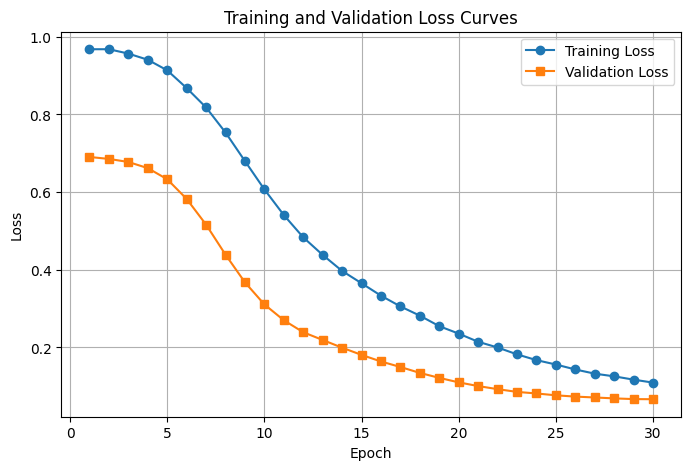

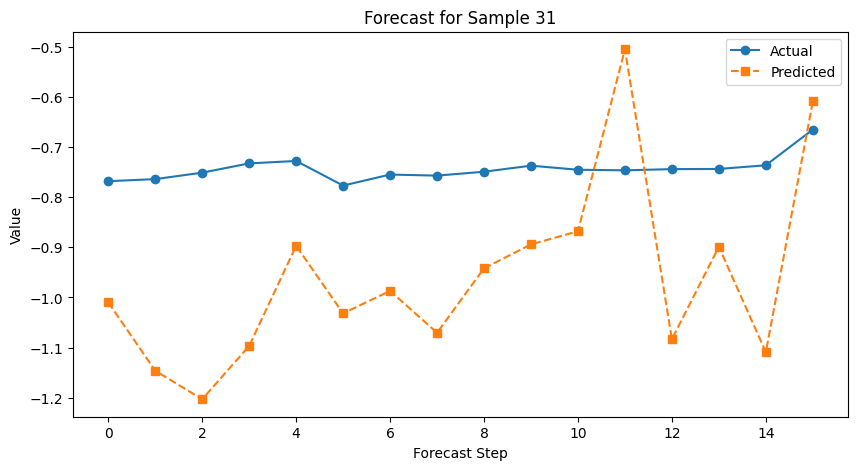

MAE for ../processed_ds/crypto-data/crypto-1/crypto-1.csv: 0.2761

Processing Site: ../processed_ds/crypto-data/crypto-4/crypto-4.csv
Train size: 1152 | Validation size: 288 | Test size: 361
Training complete!


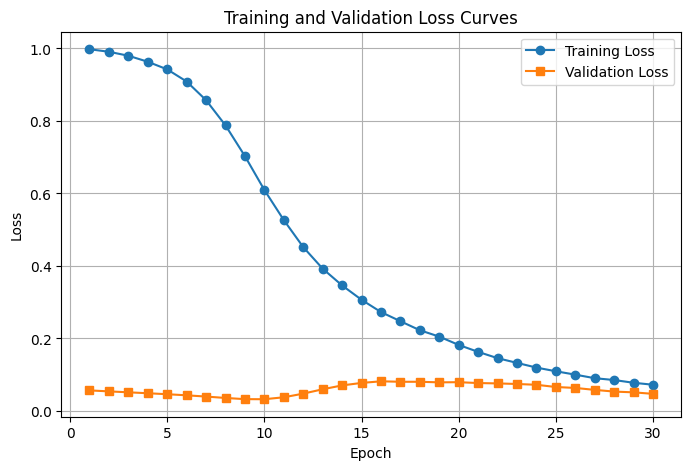

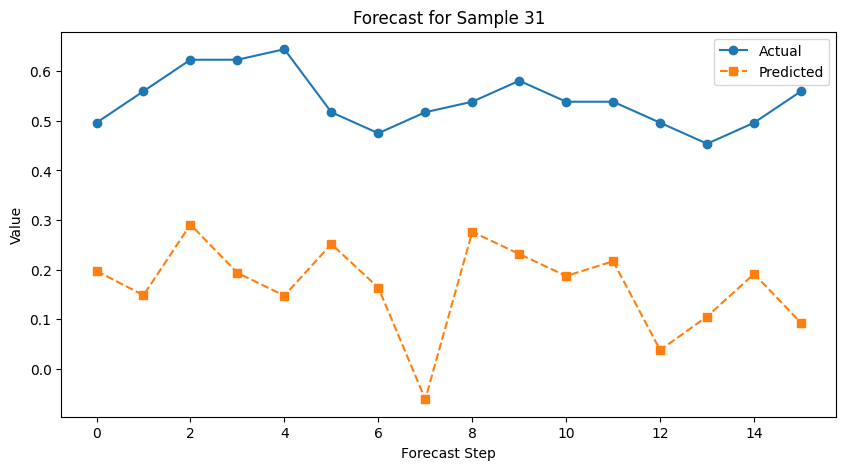

MAE for ../processed_ds/crypto-data/crypto-4/crypto-4.csv: 0.1990

Processing Site: ../processed_ds/crypto-data/crypto-2/crypto-2.csv
Train size: 1152 | Validation size: 288 | Test size: 361


KeyboardInterrupt: 

In [8]:
# # --------------------------- #
# #    Run Experiments for All Sites #
# # --------------------------- #

# # Directory containing all site data
# site_directory = "../processed_ds/air_quality_cluster/"
# min_date = "2014-09-01"
# max_date = "2014-11-12 19:00"
# num_features = 11

# site_directory = "../processed_ds/solar/"
# min_date = "2006-09-01"
# max_date = "2006-09-08 4:50"
# num_features = 10

site_directory = "../processed_ds/crypto-data/"
min_date = "2018-04-01"
max_date = "2018-06-15"
num_features = 5

# site_directory = "../processed_ds/stores_data/"
# min_date = "2013-01-16"
# max_date = "2015-07-31"
# num_features = 7
site_files = [os.path.join(site_directory, f, f"{f}.csv") for f in os.listdir(site_directory) if os.path.isdir(os.path.join(site_directory, f))]

all_mae = []

for site_path in site_files:
    print(f"\nProcessing Site: {site_path}")

    # Load data Crypto target_col = 3
    train_loader, val_loader, test_loader = load_and_preprocess_site_data(site_path, horizon=16, min_date=min_date, max_date=max_date, batch_size=32, device='cuda')

    # Define LSTM Model
    model = LSTMModel(num_features=num_features, time_window=32, output_window=16, num_labels=1,  num_layers=2, hidden_size=16, dropout=0.5)

    # Train the model
    train_model(model, train_loader, val_loader ,num_epochs=30, lr=1e-4, wd=1e-5)

    # Evaluate the model
    mae = evaluate_model(model, test_loader)
    plot_predictions(model, test_loader, sample_index=31)
    print(f"MAE for {site_path}: {mae:.4f}")
    all_mae.append(mae)

# Compute average MAE across all sites
avg_mae = np.mean(all_mae)
print(f"\nAverage MAE Across All Sites: {avg_mae:.4f}")

In [302]:
# site_directory = "../processed_ds/air_quality_cluster/"
# min_date = "2014-09-01"
# max_date = "2014-11-12 19:00"
# num_features = 11

site_directory = "../processed_ds/solar/"
min_date = "2006-09-01"
max_date = "2006-09-08 4:50"
num_features = 10

# site_directory = "../processed_ds/crypto-data/"
# min_date = "2018-04-01"
# max_date = "2018-06-15"
# num_features = 5

# site_directory = "../processed_ds/stores_data/"
# min_date = "2013-01-16"
# max_date = "2015-07-31"
# num_features = 7

train_loader, val_loader, test_loader = load_all_sites_data(
    base_dir=site_directory,
    window_size=32, 
    horizon=16, 
    batch_size=32,
    min_date=min_date, 
    max_date=max_date
    )

# Define LSTM Model
model = LSTMModel(num_features=num_features, time_window=32, output_window=16, num_labels=1,  num_layers=2, hidden_size=8, dropout=0.2)

# Train the model
train_model(model, train_loader, val_loader ,num_epochs=15, lr=1e-4, wd=1e-2)

# Evaluate the model
mae = evaluate_model(model, test_loader)
print("MAE: ", mae)

plot_predictions(model, test_loader, num_samples=100)

Total Train Size: 7968 | Validation Size: 1992 | Test Size: 2490


KeyboardInterrupt: 

Date found... Filtering now...
Date found... Filtering now...
Date found... Filtering now...
Date found... Filtering now...
Date found... Filtering now...
Date found... Filtering now...
Date found... Filtering now...
Date found... Filtering now...
Date found... Filtering now...
Date found... Filtering now...
Date found... Filtering now...
Date found... Filtering now...
Total Train Size: 13428 | Validation Size: 3348 | Test Sites: 12
Training complete!


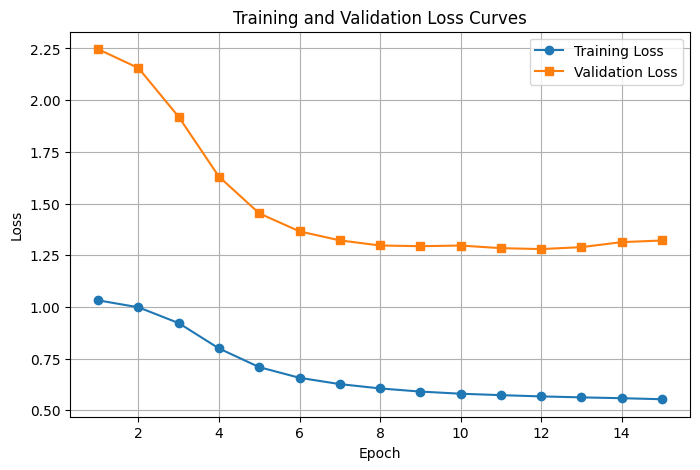

Mean MAE Across All Sites: 0.8086


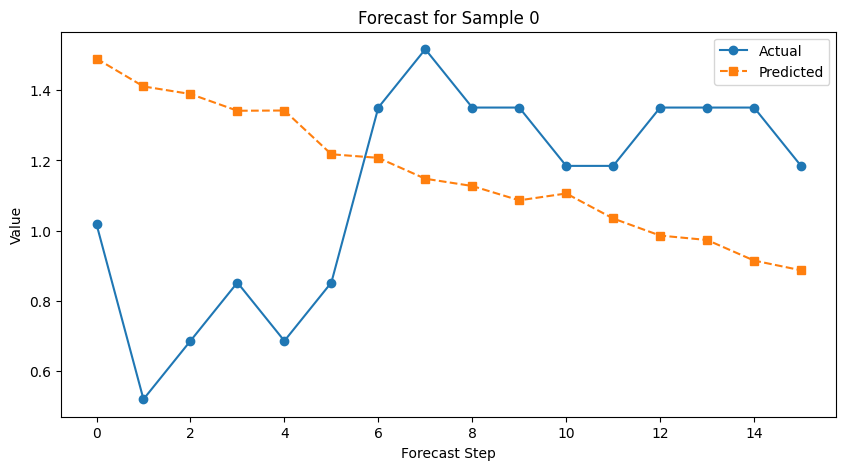

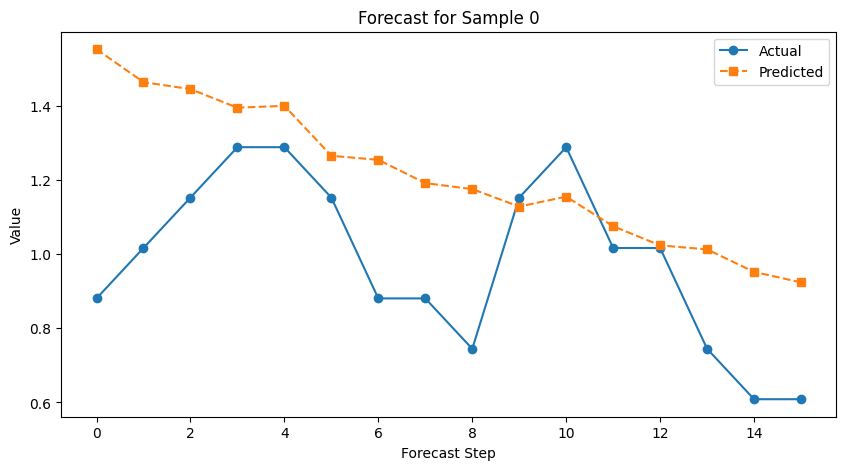

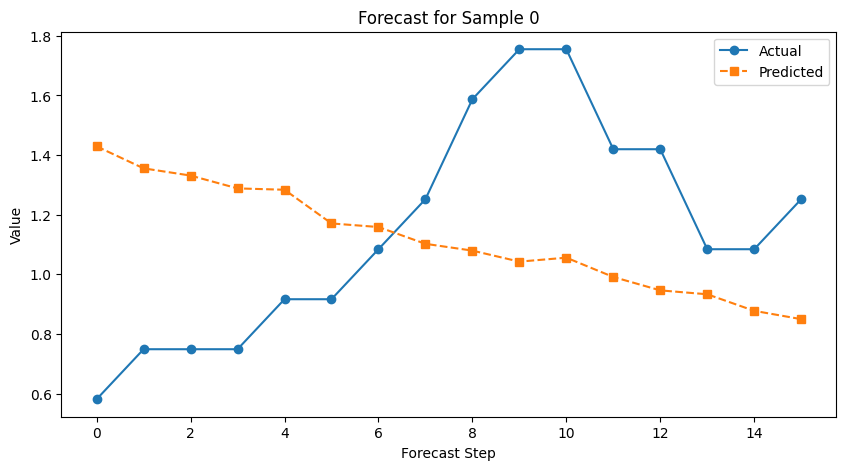

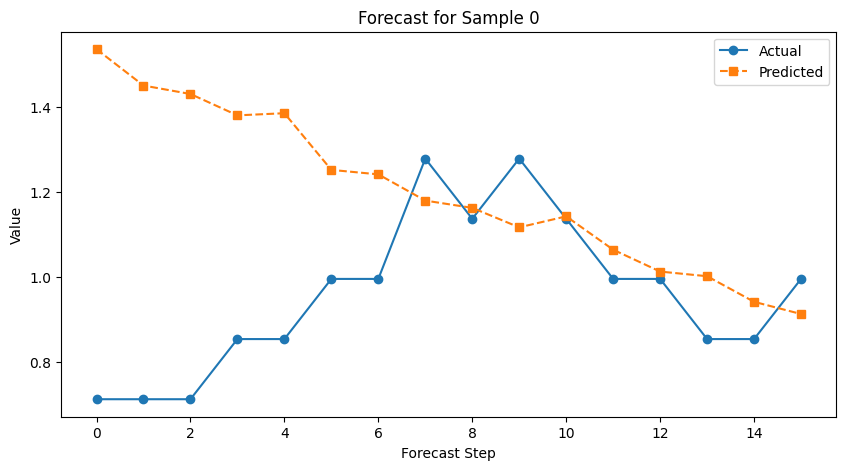

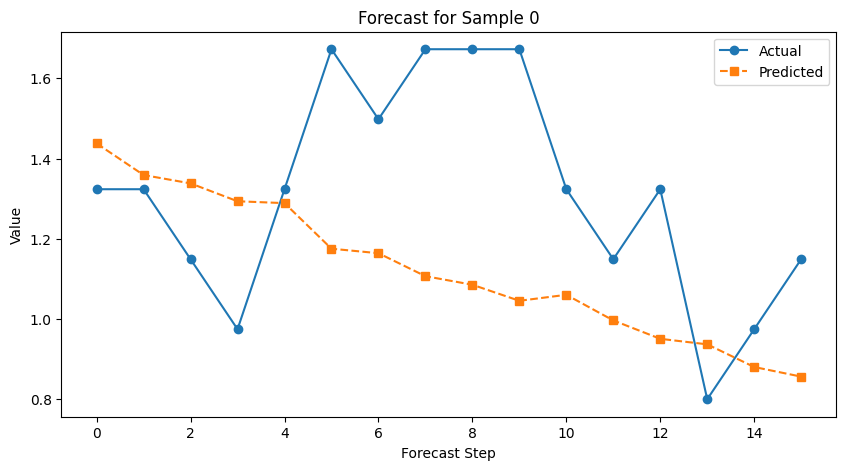

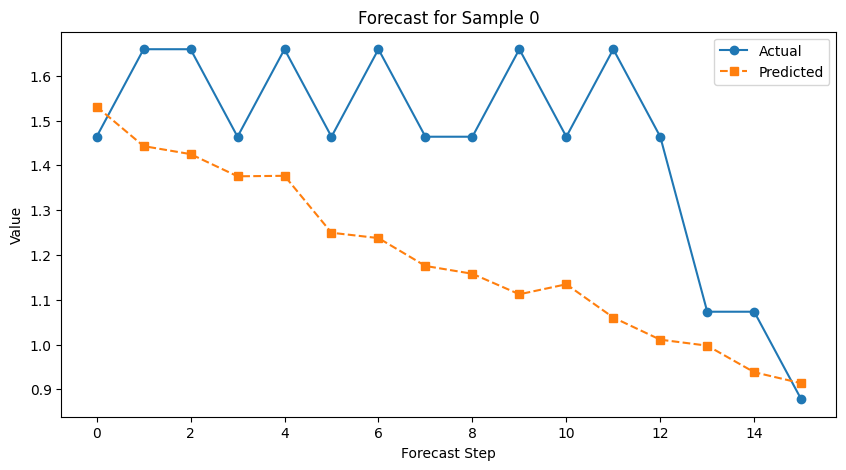

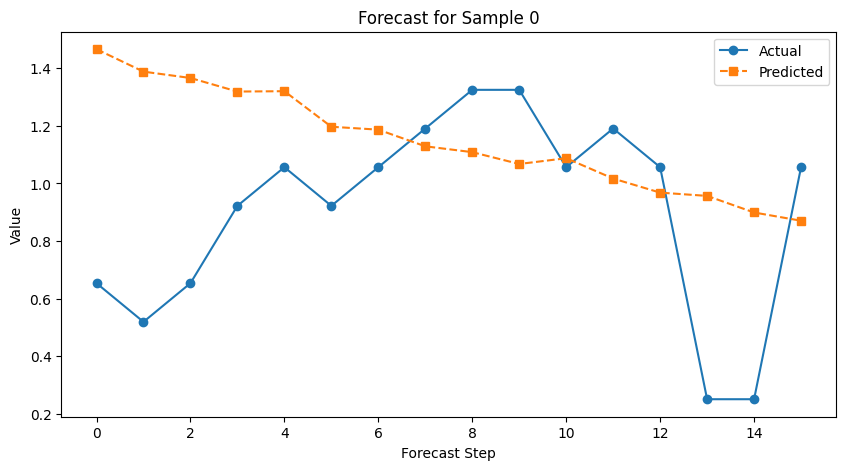

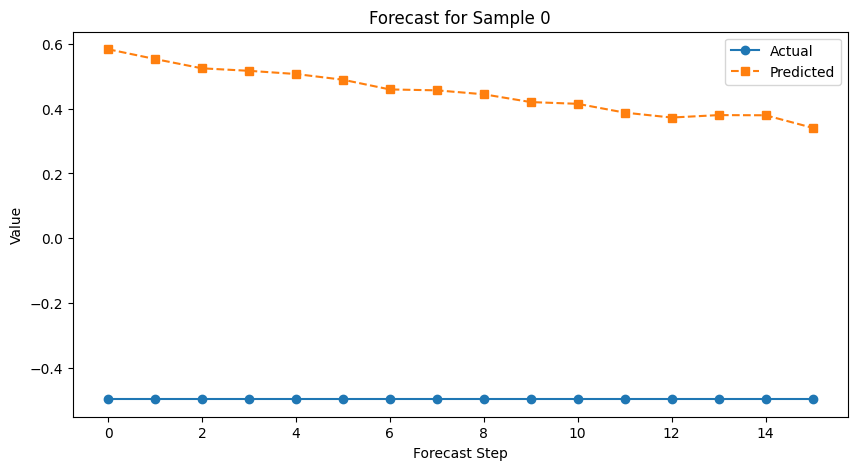

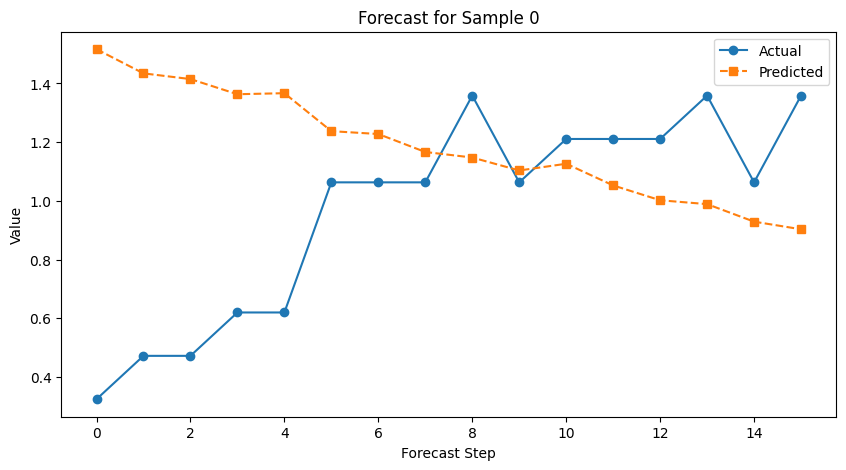

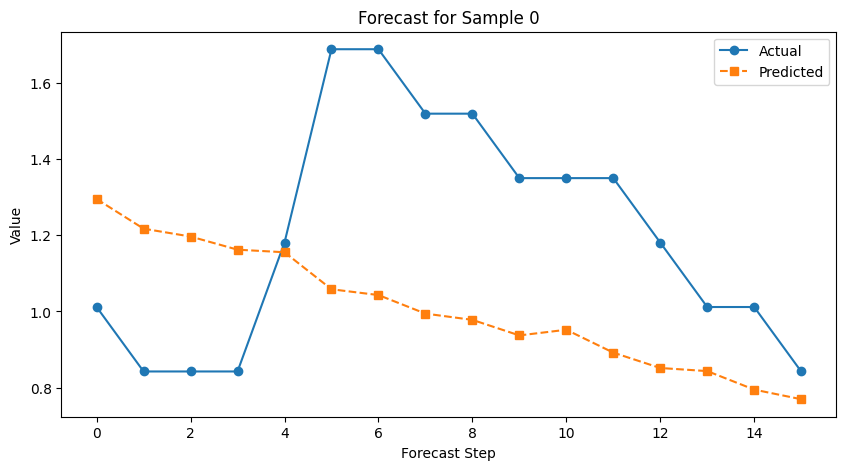

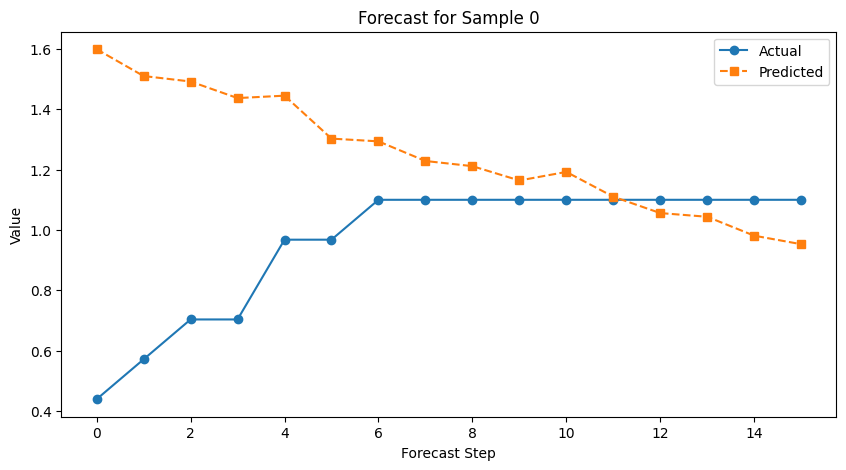

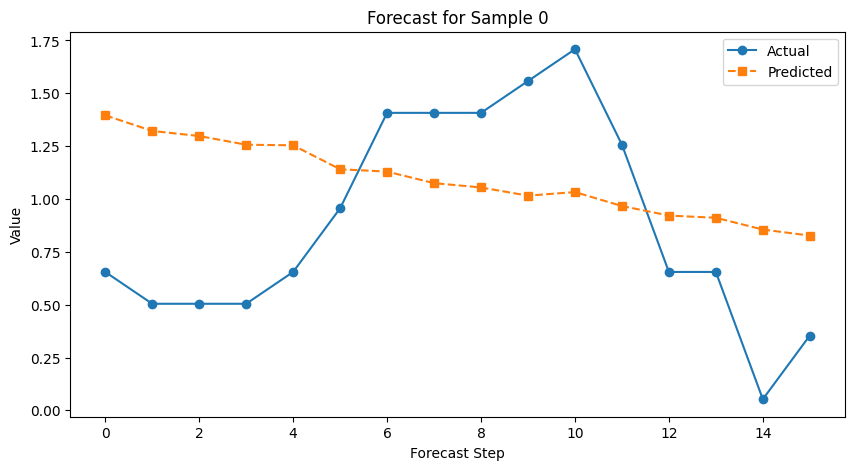

In [ ]:
site_directory = "../processed_ds/air_quality_cluster/"
min_date = "2014-09-01"
max_date = "2014-11-12 19:00"
num_features = 11

# site_directory = "../processed_ds/solar/"
# min_date = "2006-09-01"
# max_date = "2006-09-08 4:50"
# num_features = 10

# site_directory = "../processed_ds/crypto-data/"
# min_date = "2018-04-01"
# max_date = "2018-06-15"
# num_features = 5

# site_directory = "../processed_ds/stores_data/"
# min_date = "2013-01-16"
# max_date = "2015-07-31"
# num_features = 7

train_loader, val_loader, test_loaders = load_all_sites_data_independent_tests(
    base_dir=site_directory,
    window_size=32, 
    horizon=16, 
    batch_size=32,
    min_date=min_date, 
    max_date=max_date
    )

# Define LSTM Model
model = LSTMModel(num_features=num_features, time_window=32, output_window=16, num_labels=1,  num_layers=2, hidden_size=8, dropout=0.2)

# Train the model
train_model(model, train_loader, val_loader ,num_epochs=15, lr=1e-4, wd=1e-2)

# Evaluate the model
mae = evaluate_model_independent_test(model, test_loaders)

for site, test_loader in test_loaders.items():
    plot_predictions(model, test_loader)

Site: site-1 | Train: 1119 | Validation: 279 | Test: 350
Site: site-10 | Train: 1119 | Validation: 279 | Test: 350
Site: site-11 | Train: 1119 | Validation: 279 | Test: 350
Site: site-12 | Train: 1119 | Validation: 279 | Test: 350
Site: site-2 | Train: 1119 | Validation: 279 | Test: 350
Site: site-3 | Train: 1119 | Validation: 279 | Test: 350
Site: site-4 | Train: 1119 | Validation: 279 | Test: 350
Site: site-5 | Train: 1119 | Validation: 279 | Test: 350
Site: site-6 | Train: 1119 | Validation: 279 | Test: 350
Site: site-7 | Train: 1119 | Validation: 279 | Test: 350
Site: site-8 | Train: 1119 | Validation: 279 | Test: 350
Site: site-9 | Train: 1119 | Validation: 279 | Test: 350
data loader length: [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]
max dataloader length: 33 epoch iteration: 396
Epoch 1 | Train Loss: 1.0024 | Val Loss: 2.2748
Epoch 2 | Train Loss: 0.8279 | Val Loss: 1.6454
Epoch 3 | Train Loss: 0.6173 | Val Loss: 1.2419
Epoch 4 | Train Loss: 0.4898 | Val Loss: 1.0578
Epoch

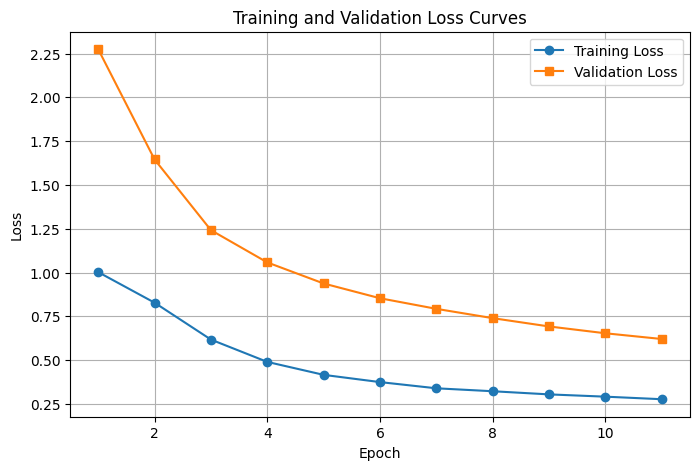

Test MAE: 0.5403
MAE:  0.5403260908055084


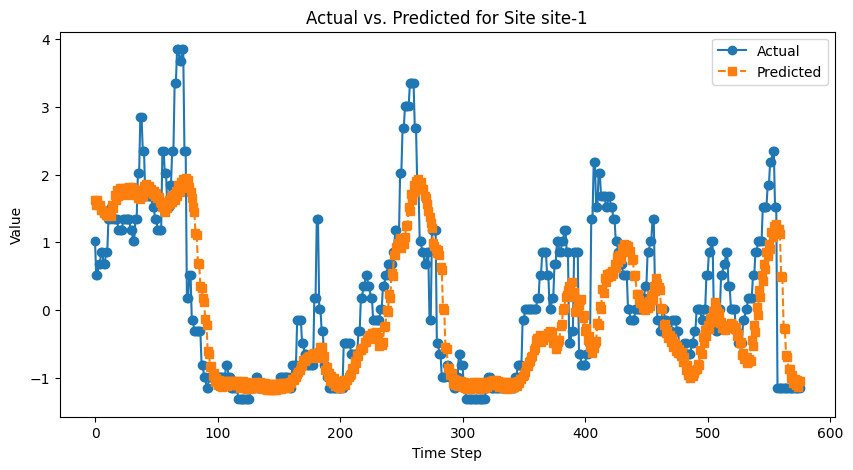

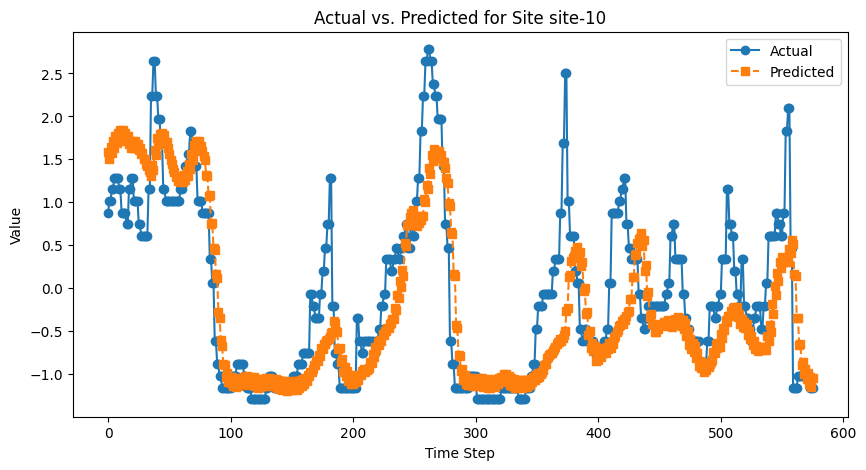

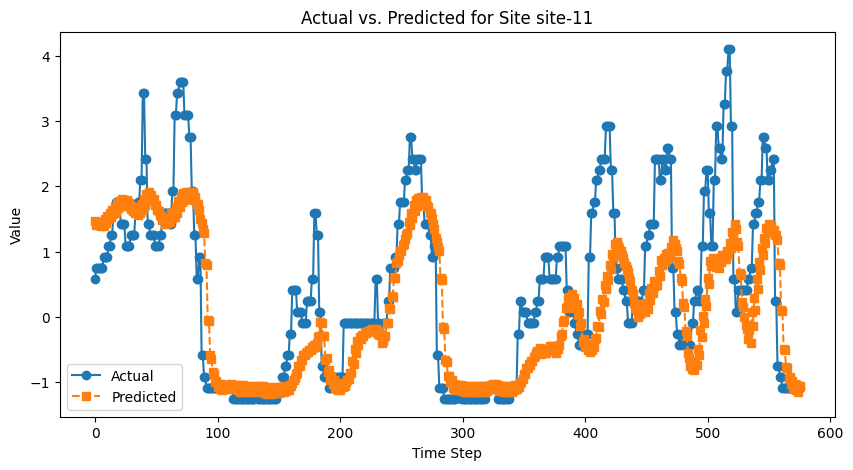

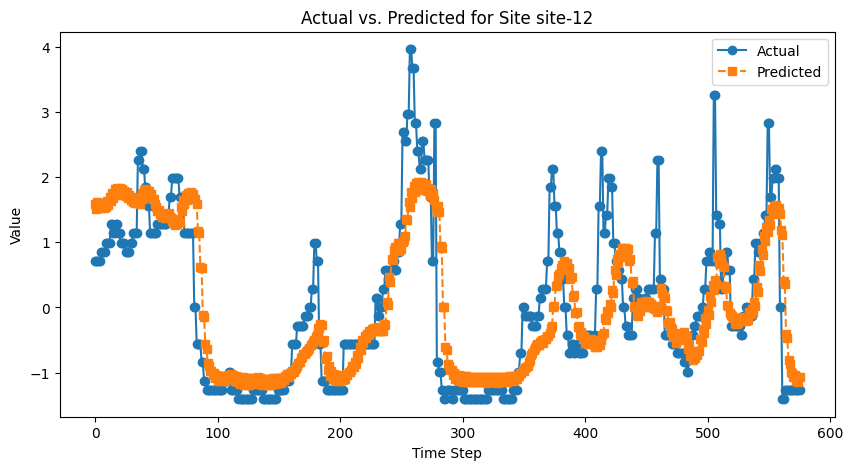

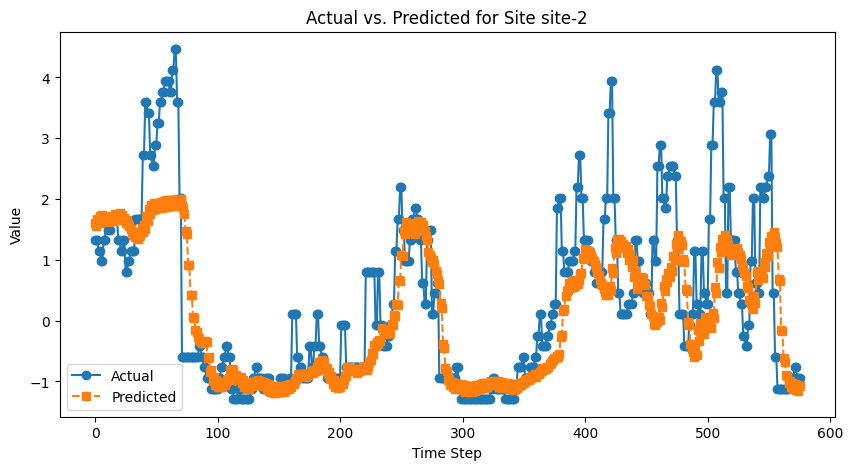

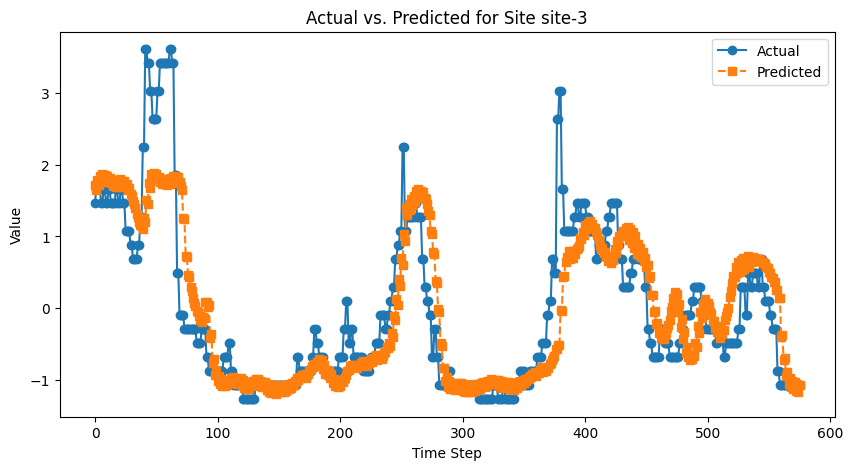

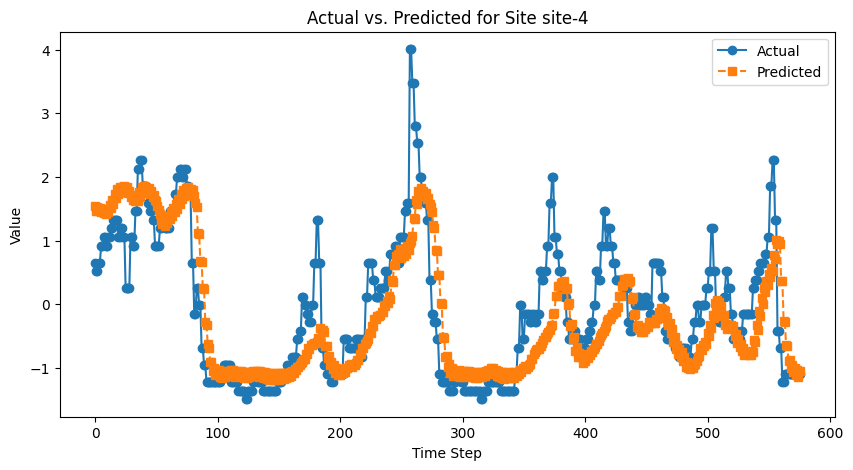

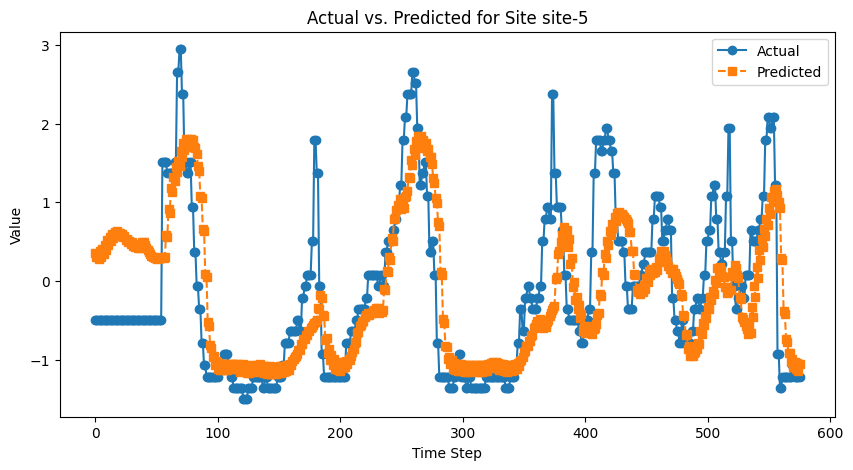

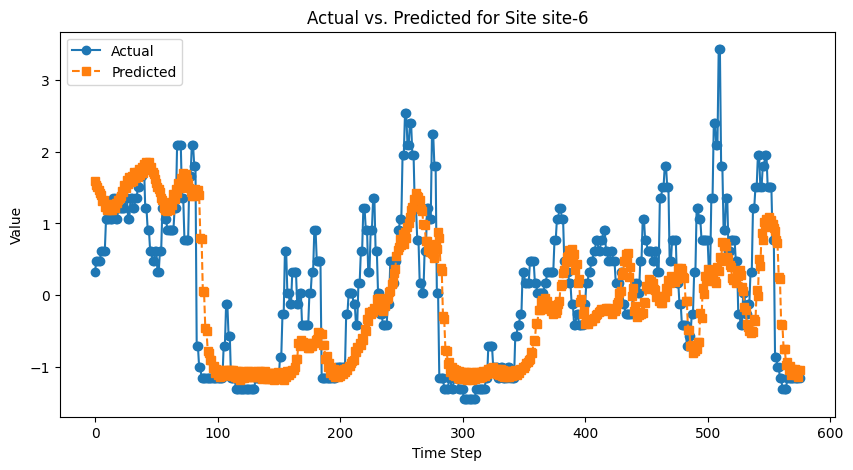

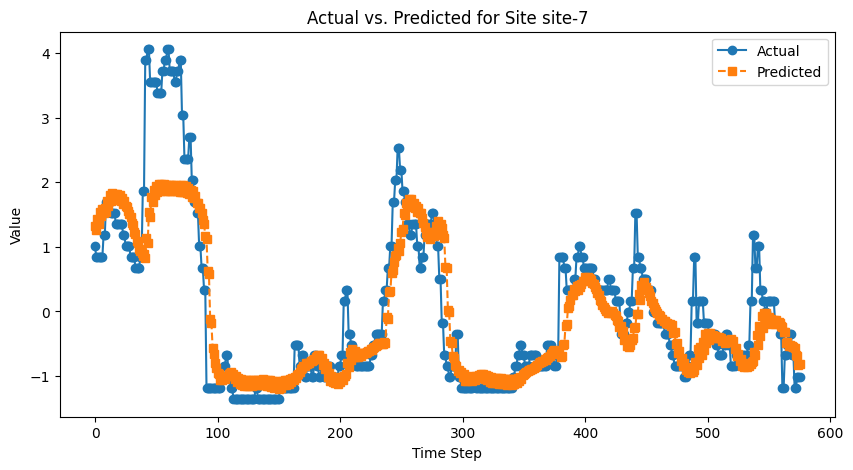

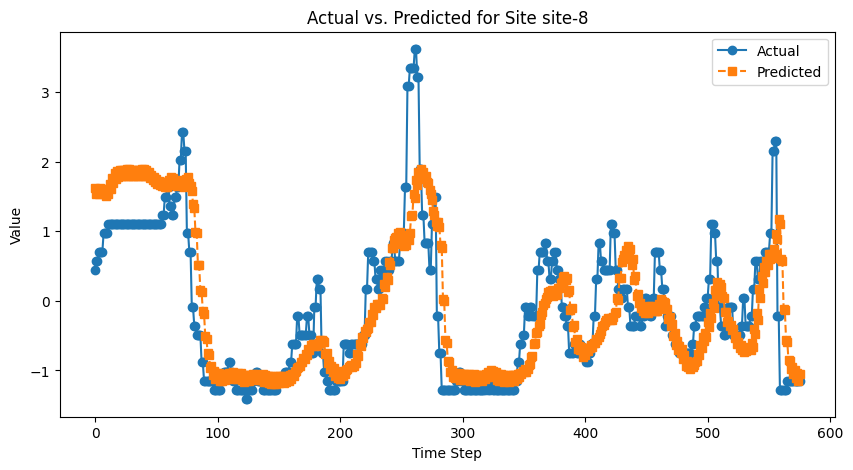

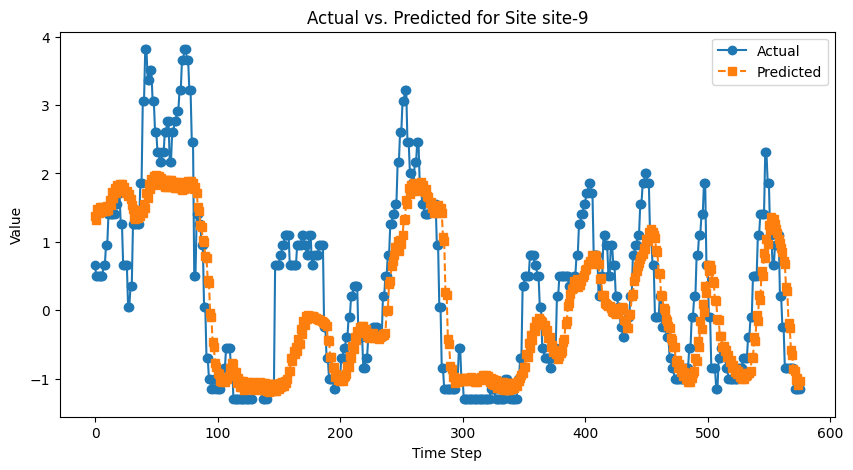

In [ ]:
site_directory = "../processed_ds/air_quality_cluster/"
min_date = "2014-09-01"
max_date = "2014-11-12 19:00"
num_features = 11

# site_directory = "../processed_ds/solar/"
# min_date = "2006-09-01"
# max_date = "2006-09-08 4:50"
# num_features = 10


# site_directory = "../processed_ds/crypto-data/"
# min_date = "2018-04-01"
# max_date = "2018-06-15"
# num_features = 5

# site_directory = "../processed_ds/stores_data/"
# min_date = "2013-01-16"
# max_date = "2015-07-31"
# num_features = 7


balanced_train_loader, val_loaders, test_loaders = load_all_sites_balanced(
    base_dir=site_directory, 
    window_size=32, 
    horizon=2, 
    batch_size=32,
    min_date=min_date, 
    max_date=max_date
)
model = LSTMModel(num_features=num_features, time_window=32, output_window=2, num_labels=1,  num_layers=2, hidden_size=8, dropout=0.5)

train_model_balanced(model, balanced_train_loader, val_loaders, num_epochs=11, lr=1e-4, wd=1e-5)

# Evaluate the model
mae = evaluate_model_balanced(model, test_loaders)
print("MAE: ", mae)

plot_predictions_balanced(model, test_loaders, 1000)

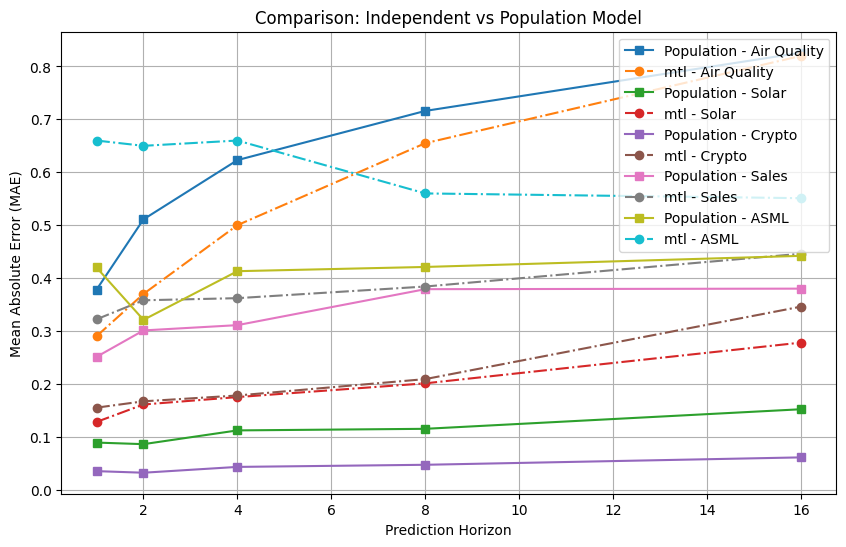

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example Data
horizons = [1, 2, 4, 8, 16]  # Horizon steps
datasets = ['Air Quality', 'Solar', 'Crypto', 'Sales', 'ASML']

# Independent Model Results (MAE for each dataset)
independent_model_results = {
    'Air Quality': [0.516, 0.563, 0.629, 0.752, 0.912],
    'Solar': [0.227, 0.236, 0.242, 0.251, 0.314],
    'Crypto': [0.382, 0.470, 0.489, 0.538, 0.567],
    'Sales': [0.325, 0.394, 0.458, 0.491, 0.513],
    'ASML': [0.412, 0.592, 0.571, 0.603, 0.717],
}

# Population Model Results (MAE for each dataset)
population_model_results = {
    'Air Quality': [0.378, 0.511, 0.623, 0.716, 0.826],
    'Solar': [0.089, 0.086, 0.112, 0.115, 0.152],
    'Crypto': [0.035, 0.032, 0.043, 0.047, 0.061],
    'Sales': [0.251, 0.301, 0.311, 0.379, 0.380],
    'ASML': [0.42, 0.321, 0.413, 0.421, 0.442],
}

mtl_model_results = {
    'Air Quality': [0.29, 0.37, 0.50, 0.655, 0.82],
    'Solar': [0.128, 0.161, 0.175, 0.201, 0.278],
    'Crypto': [0.155, 0.167, 0.178, 0.209, 0.346],
    'Sales': [0.322, 0.358, 0.362, 0.384, 0.446],
    'ASML': [0.66, 0.65, 0.66, 0.56, 0.551],
}

# Plot Settings
plt.figure(figsize=(10, 6))

for dataset in datasets:
    # plt.plot(horizons, independent_model_results[dataset], marker='o', linestyle='-', label=f'Independent - {dataset}')
    plt.plot(horizons, population_model_results[dataset], marker='s', linestyle='-', label=f'Population - {dataset}')
    plt.plot(horizons, mtl_model_results[dataset], marker='o', linestyle='-.', label=f'mtl - {dataset}')

plt.xlabel("Prediction Horizon")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Comparison: Independent vs Population Model")
plt.legend()
plt.grid(True)

plt.show()

# Transformer Setup

In [9]:

# Imports
import torch, math
import numpy as np
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn.modules.transformer import TransformerEncoderLayer

# Positional Encoding - https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(1)].transpose(0, 1)
        return self.dropout(x)

# A forcasting model
class ForecastingModel(torch.nn.Module):
    def __init__(self, 
                 seq_len=200,
                 embed_size = 16,
                 num_features=8,
                 horizon=1,
                 nhead = 2,
                 dim_feedforward = 2048,
                 dropout = 0.1,
                 conv1d_emb = True,
                 conv1d_kernel_size = 3,
                 device = "cuda"):
        super(ForecastingModel, self).__init__()

        # Set Class-level Parameters
        self.device = device
        self.conv1d_emb = conv1d_emb
        self.conv1d_kernel_size = conv1d_kernel_size
        self.seq_len = seq_len
        self.embed_size = embed_size

        # Input Embedding Component
        if conv1d_emb:
            if conv1d_kernel_size%2==0:
                raise Exception("conv1d_kernel_size must be an odd number to preserve dimensions.")
            self.conv1d_padding = conv1d_kernel_size - 1
            self.input_embedding  = nn.Conv1d(num_features, embed_size, kernel_size=conv1d_kernel_size)
        else: self.input_embedding  = nn.Linear(num_features, embed_size)

        # Positional Encoder Componet (See Code Copied from PyTorch Above)
        self.position_encoder = PositionalEncoding(d_model=embed_size, 
                                                   dropout=dropout,
                                                   max_len=seq_len)
        
        # Transformer Encoder Layer Component
        self.transformer_encoder = TransformerEncoderLayer(
            d_model = embed_size,
            nhead = nhead,
            dim_feedforward = dim_feedforward,
            dropout = dropout,
            batch_first = True
        )

        # Regression Component
        self.linear1 = nn.Linear(seq_len*embed_size, int(dim_feedforward))
        # self.linear2 = nn.Linear(int(dim_feedforward), int(dim_feedforward/2))
        # self.linear3 = nn.Linear(int(dim_feedforward/2), int(dim_feedforward/4))
        # self.linear4 = nn.Linear(int(dim_feedforward/4), int(dim_feedforward/16))
        # self.linear5 = nn.Linear(int(dim_feedforward/16), int(dim_feedforward/64))
        self.outlayer = nn.Linear(int(dim_feedforward), horizon)

        # Basic Components
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    # Model Forward Pass
    def forward(self, x):
        src_mask = self._generate_square_subsequent_mask()
        src_mask.to(self.device)
        if self.conv1d_emb: 
            x = F.pad(x, (0, 0, self.conv1d_padding, 0), "constant", -1)
            x = self.input_embedding(x.transpose(1, 2))
            x = x.transpose(1, 2)
        else: 
            x = self.input_embedding(x)
        x = self.position_encoder(x)
        x = self.transformer_encoder(x, src_mask=src_mask).reshape((-1, self.seq_len*self.embed_size))
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        # x = self.linear2(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        # x = self.linear3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        # x = self.linear4(x)
        # x = self.relu(x)
        x = self.dropout(x)
        # x = self.linear5(x)
        x = self.relu(x)
        return self.outlayer(x)
    
    # Function Copied from PyTorch Library to create upper-triangular source mask
    def _generate_square_subsequent_mask(self):
        return torch.triu(
            torch.full((self.seq_len, self.seq_len), float('-inf'), dtype=torch.float32, device=self.device),
            diagonal=1,
        )

Epoch 1/2: Loss=0.09373515844345093
Epoch 2/2: Loss=0.059217408299446106


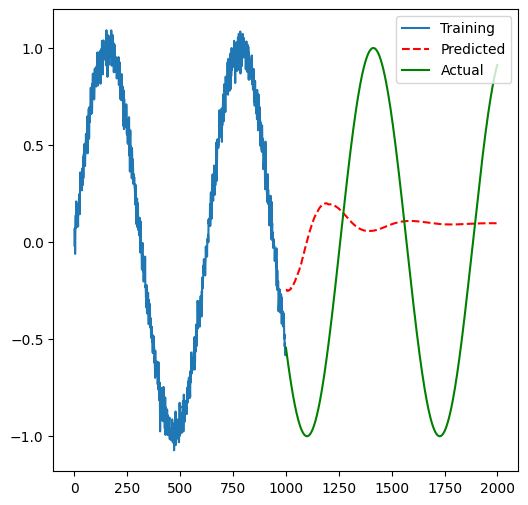

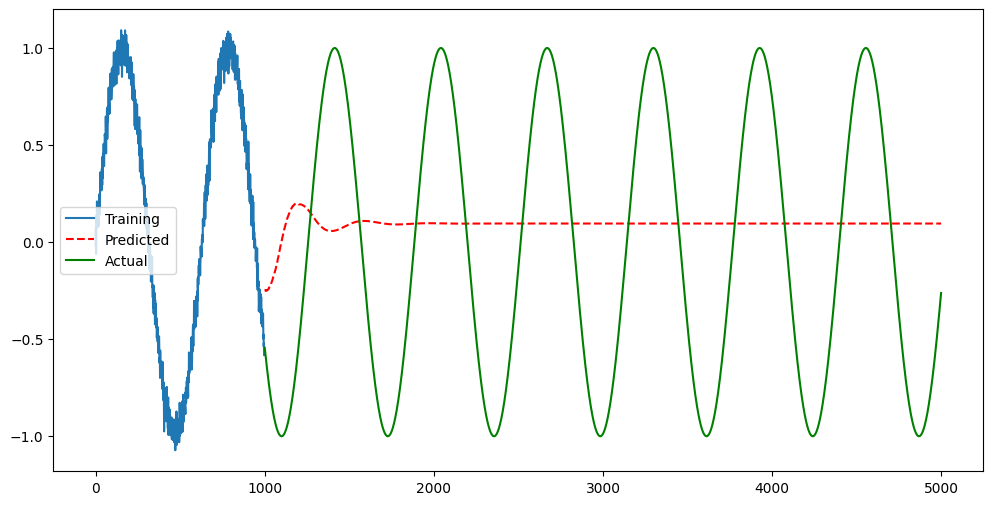

In [15]:
from torch.optim.lr_scheduler import ExponentialLR
# Get a noisy sin wave
DATA_SIZE = 1000
x = np.sin(np.linspace(0, 10, DATA_SIZE))
x = x + np.random.normal(0, 0.05, DATA_SIZE)


# Create a dataset
seq_len = 200
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, seq_len, 1))
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, 1))


# Training Loop
device="cuda"
EPOCHS = 2
BATCH_SIZE = 1
LEARNING_RATE = 2.2e-6
model = ForecastingModel(seq_len, embed_size=8, num_features=1 ,nhead=2, dim_feedforward=1024, dropout=0, device=device)
model.to(device)
model.train()
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)
dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
for epoch in range(EPOCHS):
    for xx, yy in dataloader:
        optimizer.zero_grad()
        out = model(xx)
        loss = criterion(out, yy)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")


# Prediction Loop
FORCAST = 1000
model.eval()
for ff in range(FORCAST):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape(1, xx.shape[0], 1).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))


# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORCAST], 'r--', label="Predicted")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10, 20, DATA_SIZE)), 'g-', label="Actual")
plt.legend()


# Prediction Loop
FORCAST_EXTENDED = 3000
model.eval()
for ff in range(FORCAST_EXTENDED):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape(1, xx.shape[0], 1).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))


# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORCAST+FORCAST_EXTENDED], 'r--', label="Predicted")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10, 50, FORCAST+FORCAST_EXTENDED)), 'g-', label="Actual")
plt.legend()

# Transformer Simple Independent Model


In [813]:

def run_experiment_mae_independent():
    # --------------------------- #
    #    Run Experiments for All Sites #
    # --------------------------- #

    # Directory containing all site data
    # site_directory = "../processed_ds/air_quality_cluster/"
    # min_date = "2014-09-01"
    # max_date = "2014-11-12 19:00"
    # num_features = 11

    # site_directory = "../processed_ds/solar/"
    # min_date = "2006-09-01"
    # max_date = "2006-09-08 4:50"
    # num_features = 10

    # site_directory = "../processed_ds/crypto-data/"
    # min_date = "2018-04-01"
    # max_date = "2018-06-15"
    # num_features = 5

    site_directory = "../processed_ds/stores_data/"
    min_date = "2013-01-16"
    max_date = "2015-07-31"
    num_features = 7
    
    # Add Industry Data.
    
    site_files = [os.path.join(site_directory, f, f"{f}.csv") for f in os.listdir(site_directory) if os.path.isdir(os.path.join(site_directory, f))]

    site_mae_list = []
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seq_len = 32
    embed_size = 128
    batch_size = 32
    num_epochs = 30
    dim_feedforward = 512
    dropout = 0.1
    horizon = 8

    for site_path in site_files[0:30]:
        # print(f"\nProcessing Site: {site_path}")

        # Load data Crypto target_col = 3
        train_loader, val_loader, test_loader = load_and_preprocess_site_data(site_path, horizon=horizon, min_date=min_date, max_date=max_date, batch_size=batch_size, device='cuda')

        model = ForecastingModel(seq_len=seq_len, embed_size=embed_size, horizon=horizon ,num_features=num_features, dim_feedforward=dim_feedforward, dropout=dropout ,device=device)
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print("Total trainable parameters:", total_params)
        model.to(device)
        
        # Define optimizer, scheduler, and loss criterion
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        scheduler = ExponentialLR(optimizer, gamma=0.95)
        criterion = nn.MSELoss()
        
        # For plotting loss curves
        train_losses = []
        val_losses = []
        
        # Training loop with validation
        model.train()
        for epoch in range(num_epochs):
            epoch_train_losses = []
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                output = model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
                epoch_train_losses.append(loss.item())
            scheduler.step()
            avg_train_loss = np.mean(epoch_train_losses)
            train_losses.append(avg_train_loss)
            
            # Validation pass
            model.eval()
            epoch_val_losses = []
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    val_output = model(batch_x)
                    val_loss = criterion(val_output, batch_y)
                    epoch_val_losses.append(val_loss.item())
            avg_val_loss = np.mean(epoch_val_losses)
            val_losses.append(avg_val_loss)
            # print(f"Site: {site_path}, Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            model.train()
        
        # Evaluate the model on test data using mini-batches, compute MAE
        model.eval()
        mae_criterion = nn.L1Loss()
        test_preds = []
        test_targets = []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                preds = model(batch_x)
                test_preds.append(preds.cpu())
                test_targets.append(batch_y.cpu())
        test_preds = torch.cat(test_preds, dim=0)
        test_targets = torch.cat(test_targets, dim=0)
        test_mae = mae_criterion(test_preds, test_targets)
        print(f"Site: {site_path}, Test MAE: {test_mae.item():.4f}")
        site_mae_list.append(test_mae.item())
        
        
        # Plot training and validation loss for current site
        # plt.figure(figsize=(10, 5))
        # plt.plot(train_losses, label="Train Loss")
        # plt.plot(val_losses, label="Validation Loss")
        # plt.xlabel("Epoch")
        # plt.ylabel("MSE Loss")
        # plt.title(f"Train vs. Validation Loss for {site_path}")
        # plt.legend()
        # plt.show()
        
        # Plot Predictions
        # plot_predictions(model, test_loader, sample_index=28)
    # Compute and print the average MAE across all sites
    avg_mae = np.mean(site_mae_list)
    print(f"\nAverage MAE across all sites: {avg_mae:.4f}")
      

In [814]:
run_experiment_mae_independent() # Usually fore long term, Forecast deviates

Train size: 593 | Validation size: 148 | Test size: 186
Total trainable parameters: 2302856
Site: ../processed_ds/stores_data/store-631/store-631.csv, Test MAE: 0.3728
Train size: 593 | Validation size: 148 | Test size: 186
Total trainable parameters: 2302856
Site: ../processed_ds/stores_data/store-602/store-602.csv, Test MAE: 0.3957
Train size: 593 | Validation size: 148 | Test size: 186
Total trainable parameters: 2302856
Site: ../processed_ds/stores_data/store-873/store-873.csv, Test MAE: 0.3276
Train size: 593 | Validation size: 148 | Test size: 186
Total trainable parameters: 2302856
Site: ../processed_ds/stores_data/store-734/store-734.csv, Test MAE: 0.5307
Train size: 593 | Validation size: 148 | Test size: 186
Total trainable parameters: 2302856
Site: ../processed_ds/stores_data/store-844/store-844.csv, Test MAE: 0.4109
Train size: 593 | Validation size: 148 | Test size: 186
Total trainable parameters: 2302856
Site: ../processed_ds/stores_data/store-560/store-560.csv, Test MAE:

In [10]:
# def run_population_experiment():
#     # --------------------------- #
#     #    Run Experiments for All Sites #
#     # --------------------------- #

#     # Uncomment the desired dataset block:
#     site_directory = "../processed_ds/air_quality_cluster/"
#     min_date = "2014-09-01"
#     max_date = "2014-11-12 19:00"
#     num_features = 11

#     # site_directory = "../processed_ds/solar/"
#     # min_date = "2006-09-01"
#     # max_date = "2006-09-08 4:50"
#     # num_features = 10

#     # site_directory = "../processed_ds/crypto-data/"
#     # min_date = "2018-04-01"
#     # max_date = "2018-06-15"
#     # num_features = 5

#     # site_directory = "../processed_ds/stores_data/"
#     # min_date = "2013-01-16"
#     # max_date = "2015-07-31"
#     # num_features = 7
    
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     seq_len = 32
#     embed_size = 128
#     batch_size = 32
#     num_epochs = 30
#     dim_feedforward = 512
#     dropout = 0.1
#     horizon = 4
    
#     # Load DataLoaders for training, validation, and independent test sets for all sites.
#     # (Assumes load_all_sites_data_independent_tests returns:
#     #   train_loader, val_loader, and test_loaders as a dictionary keyed by site name)
#     train_loader, val_loader, test_loaders = load_all_sites_data_independent_tests(
#         base_dir=site_directory,
#         window_size=seq_len, 
#         horizon=horizon, 
#         batch_size=batch_size,
#         min_date=min_date, 
#         max_date=max_date,
#         device=device
#     )
    
#     # Instantiate and send model to device
#     model = ForecastingModel(seq_len=seq_len, embed_size=embed_size, num_features=num_features, 
#                                 dim_feedforward=dim_feedforward, dropout=dropout, device=device, horizon = horizon)
#     total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     print("Total trainable parameters:", total_params)
#     model.to(device)
    
#     # Define optimizer, scheduler, and loss criterion
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
#     scheduler = ExponentialLR(optimizer, gamma=1)
#     criterion = nn.MSELoss()
    
#     # Lists for tracking loss curves
#     train_losses = []
#     val_losses = []
    
#     # Training loop with validation
#     model.train()
#     for epoch in range(num_epochs):
#         print(f"Epoch {epoch+1}/{num_epochs}")
#         epoch_train_losses = []
#         for batch_x, batch_y in train_loader:
#             optimizer.zero_grad()
#             output = model(batch_x)
#             loss = criterion(output, batch_y)
#             loss.backward()
#             optimizer.step()
#             epoch_train_losses.append(loss.item())
#         scheduler.step()
#         avg_train_loss = np.mean(epoch_train_losses)
#         train_losses.append(avg_train_loss)
        
#         # Validation pass
#         model.eval()
#         epoch_val_losses = []
#         with torch.no_grad():
#             for batch_x, batch_y in val_loader:
#                 val_output = model(batch_x)
#                 val_loss = criterion(val_output, batch_y)
#                 epoch_val_losses.append(val_loss.item())
#         avg_val_loss = np.mean(epoch_val_losses)
#         val_losses.append(avg_val_loss)
#         print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
#         model.train()
    
#     # Plot training and validation loss curves after training completes.
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(10, 5))
#     plt.plot(train_losses, label="Train Loss")
#     plt.plot(val_losses, label="Validation Loss")
#     plt.xlabel("Epoch")
#     plt.ylabel("MSE Loss")
#     plt.title("Train vs. Validation Loss")
#     plt.legend()
#     plt.show()
    
#     # Evaluate the model on test data using mini-batches and compute MAE
#     model.eval()
#     mae_criterion = nn.L1Loss()
#     site_mae_list = []
    
#     with torch.no_grad():
#         # Loop through each site's test loader
#         for site, test_loader in test_loaders.items():
#             site_preds = []
#             site_targets = []
#             for batch_x, batch_y in test_loader:
#                 preds = model(batch_x)
#                 site_preds.append(preds.cpu())
#                 site_targets.append(batch_y.cpu())
#             site_preds_cat = torch.cat(site_preds, dim=0)
#             site_targets_cat = torch.cat(site_targets, dim=0)
#             test_mae = mae_criterion(site_preds_cat, site_targets_cat)
#             site_mae_list.append(test_mae.item())
#             print(f"Site: {site}, Test MAE: {test_mae.item():.4f}")
    
#     print("Site MAE:", site_mae_list)
#     avg_mae = np.mean(site_mae_list)
#     print(f"\nAverage MAE across all sites: {avg_mae:.4f}")
    
    

In [11]:
# run_population_experiment() #use less.

# TRANSFORMER BASED SIMPLE GLOBAL MODEL

In [20]:
import torch
import numpy as np
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

def run_global_model_experiment():
    # --------------------------- #
    #    Run Experiments for All Sites #
    # --------------------------- #

    # Uncomment the desired dataset block:
    datasets = [
        {
            "site_directory": "../processed_ds/air_quality_cluster/",
            "min_date": "2014-09-01",
            "max_date": "2014-11-12 19:00",
            "num_features": 11
        },
        {
            "site_directory": "../processed_ds/solar/",
            "min_date": "2006-09-01",
            "max_date": "2006-09-08 4:50",
            "num_features": 10
        },
        {
            "site_directory": "../processed_ds/crypto-data/",
            "min_date": "2018-04-01",
            "max_date": "2018-06-15",
            "num_features": 5
        },
        # {
        #     "site_directory": "../processed_ds/stores_data/",
        #     "min_date": "2013-01-16",
        #     "max_date": "2015-07-31",
        #     "num_features": 7
        # }
    ]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    seq_len = 32
    embed_size = 128
    batch_size = 32
    num_epochs = 30
    dim_feedforward = 512
    dropout = 0.1

    # Horizons to run
    horizons = [1, 2, 4, 8, 16]

    # Output file for logging results
    output_file = "output.txt"
    with open(output_file, 'a') as f:
        f.write("\n================== Global Simple Transformer Experiment Results ==================\n")

    for dataset in datasets:
        site_directory = dataset["site_directory"]
        min_date = dataset["min_date"]
        max_date = dataset["max_date"]
        num_features = dataset["num_features"]

        print(f"\nRunning experiments for dataset: {site_directory}")
        with open(output_file, 'a') as f:
            f.write(f"\nDataset: {site_directory}\n")

        for horizon in horizons:  # Specific horizons
            print(f"\nStarting experiment for horizon: {horizon}")
            with open(output_file, 'a') as f:
                f.write(f"\n--- Horizon: {horizon} ---\n")

            # Load data
            balanced_train_loader, val_loaders, test_loaders = load_all_sites_balanced(
                base_dir=site_directory,
                window_size=seq_len,
                horizon=horizon,
                batch_size=batch_size,
                min_date=min_date,
                max_date=max_date,
                device=device
            )

            # Instantiate model
            model = ForecastingModel(
                seq_len=seq_len,
                embed_size=embed_size,
                num_features=num_features,
                horizon=horizon,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                device=device
            ).to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
            scheduler = ExponentialLR(optimizer, gamma=0.95)
            criterion = nn.MSELoss()

            train_losses, val_losses = [], []

            # Training
            model.train()
            for epoch in range(num_epochs):
                epoch_train_losses = []
                print(f"Epoch {epoch+1}/{num_epochs} for horizon {horizon}")
                for (batch, chosen_index) in balanced_train_loader:
                    batch_x, batch_y = batch
                    optimizer.zero_grad()
                    output = model(batch_x)
                    loss = criterion(output, batch_y)
                    loss.backward()
                    optimizer.step()
                    epoch_train_losses.append(loss.item())

                scheduler.step()
                avg_train_loss = np.mean(epoch_train_losses)
                train_losses.append(avg_train_loss)

                # Validation
                model.eval()
                running_val_loss, val_batches = 0.0, 0
                with torch.no_grad():
                    for site, val_loader in val_loaders.items():
                        for batch_x, batch_y in val_loader:
                            output = model(batch_x)
                            loss = criterion(output, batch_y)
                            running_val_loss += loss.item()
                            val_batches += 1

                avg_val_loss = running_val_loss / val_batches if val_batches > 0 else float('inf')
                val_losses.append(avg_val_loss)

                print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
                model.train()

            # Plot Loss Curves
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label="Train Loss")
            plt.plot(val_losses, label="Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("MSE Loss")
            plt.title(f"Train vs. Validation Loss (Horizon={horizon})")
            plt.legend()
            plt.show()

            # Evaluation on Test Data (MAE)
            model.eval()
            mae_criterion = nn.L1Loss()
            site_mae_list = []

            with torch.no_grad():
                for site, test_loader in test_loaders.items():
                    site_preds, site_targets = [], []
                    for batch_x, batch_y in test_loader:
                        preds = model(batch_x)
                        site_preds.append(preds.cpu())
                        site_targets.append(batch_y.cpu())
                    site_preds_cat = torch.cat(site_preds, dim=0)
                    site_targets_cat = torch.cat(site_targets, dim=0)
                    test_mae = mae_criterion(site_preds_cat, site_targets_cat)
                    site_mae_list.append(test_mae.item())
                    print(f"Site: {site}, Test MAE (Horizon {horizon}): {test_mae.item():.4f}")

                    # Append site-wise MAE to output.txt
                    with open(output_file, 'a') as f:
                        f.write(f"Site: {site}, Test MAE (Horizon {horizon}): {test_mae.item():.4f}\n")

            avg_mae = np.mean(site_mae_list)
            with open(output_file, 'a') as f:
                f.write(f"Site-wise MAE list (Horizon {horizon}): {site_mae_list}\n")
            print(f"\nAverage MAE across all sites (Horizon {horizon}): {avg_mae:.4f}")

            # Append average MAE to output.txt
            with open(output_file, 'a') as f:
                f.write(f"Average MAE across all sites (Horizon {horizon}): {avg_mae:.4f}\n")




Running experiments for dataset: ../processed_ds/air_quality_cluster/

Starting experiment for horizon: 1
Site: site-1 | Train: 1119 | Validation: 279 | Test: 350
Site: site-10 | Train: 1119 | Validation: 279 | Test: 350
Site: site-11 | Train: 1119 | Validation: 279 | Test: 350
Site: site-12 | Train: 1119 | Validation: 279 | Test: 350
Site: site-2 | Train: 1119 | Validation: 279 | Test: 350
Site: site-3 | Train: 1119 | Validation: 279 | Test: 350
Site: site-4 | Train: 1119 | Validation: 279 | Test: 350
Site: site-5 | Train: 1119 | Validation: 279 | Test: 350
Site: site-6 | Train: 1119 | Validation: 279 | Test: 350
Site: site-7 | Train: 1119 | Validation: 279 | Test: 350
Site: site-8 | Train: 1119 | Validation: 279 | Test: 350
Site: site-9 | Train: 1119 | Validation: 279 | Test: 350
data loader length: [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]
max dataloader length: 33 epoch iteration: 396
Epoch 1/30 for horizon 1
Epoch 1 | Train Loss: 0.6654 | Val Loss: 0.9961
Epoch 2/30 for ho

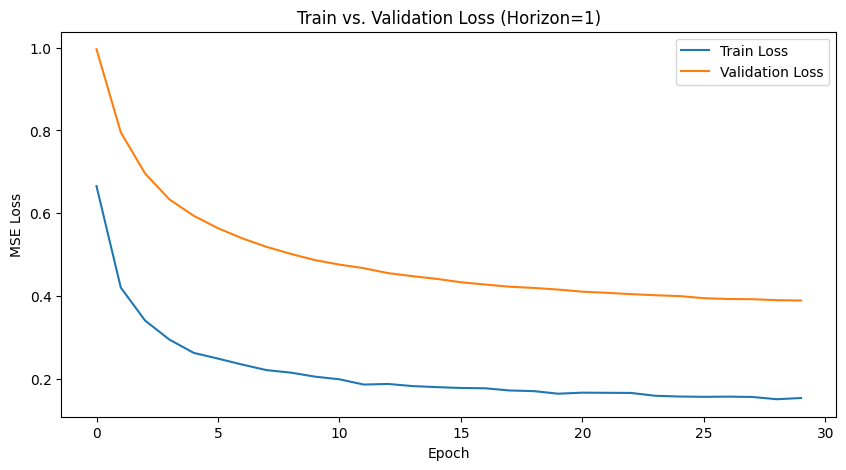

Site: site-1, Test MAE (Horizon 1): 0.4791
Site: site-10, Test MAE (Horizon 1): 0.3737
Site: site-11, Test MAE (Horizon 1): 0.5762
Site: site-12, Test MAE (Horizon 1): 0.4524
Site: site-2, Test MAE (Horizon 1): 0.5426
Site: site-3, Test MAE (Horizon 1): 0.3553
Site: site-4, Test MAE (Horizon 1): 0.3574
Site: site-5, Test MAE (Horizon 1): 0.4512
Site: site-6, Test MAE (Horizon 1): 0.4726
Site: site-7, Test MAE (Horizon 1): 0.3548
Site: site-8, Test MAE (Horizon 1): 0.3694
Site: site-9, Test MAE (Horizon 1): 0.4709

Average MAE across all sites (Horizon 1): 0.4380

Starting experiment for horizon: 2
Site: site-1 | Train: 1119 | Validation: 279 | Test: 350
Site: site-10 | Train: 1119 | Validation: 279 | Test: 350
Site: site-11 | Train: 1119 | Validation: 279 | Test: 350
Site: site-12 | Train: 1119 | Validation: 279 | Test: 350
Site: site-2 | Train: 1119 | Validation: 279 | Test: 350
Site: site-3 | Train: 1119 | Validation: 279 | Test: 350
Site: site-4 | Train: 1119 | Validation: 279 | Tes

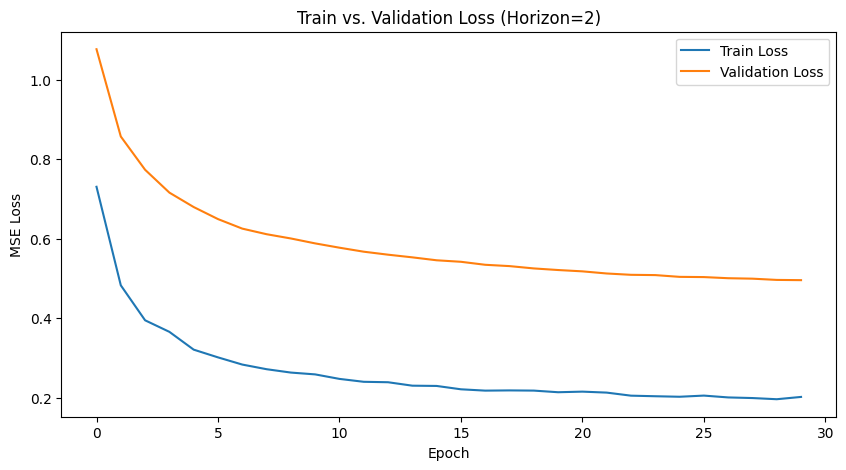

Site: site-1, Test MAE (Horizon 2): 0.5403
Site: site-10, Test MAE (Horizon 2): 0.4446
Site: site-11, Test MAE (Horizon 2): 0.6818
Site: site-12, Test MAE (Horizon 2): 0.5357
Site: site-2, Test MAE (Horizon 2): 0.6339
Site: site-3, Test MAE (Horizon 2): 0.3896
Site: site-4, Test MAE (Horizon 2): 0.4259
Site: site-5, Test MAE (Horizon 2): 0.5372
Site: site-6, Test MAE (Horizon 2): 0.5320
Site: site-7, Test MAE (Horizon 2): 0.3832
Site: site-8, Test MAE (Horizon 2): 0.4012
Site: site-9, Test MAE (Horizon 2): 0.5443

Average MAE across all sites (Horizon 2): 0.5041

Starting experiment for horizon: 4
Site: site-1 | Train: 1119 | Validation: 279 | Test: 350
Site: site-10 | Train: 1119 | Validation: 279 | Test: 350
Site: site-11 | Train: 1119 | Validation: 279 | Test: 350
Site: site-12 | Train: 1119 | Validation: 279 | Test: 350
Site: site-2 | Train: 1119 | Validation: 279 | Test: 350
Site: site-3 | Train: 1119 | Validation: 279 | Test: 350
Site: site-4 | Train: 1119 | Validation: 279 | Tes

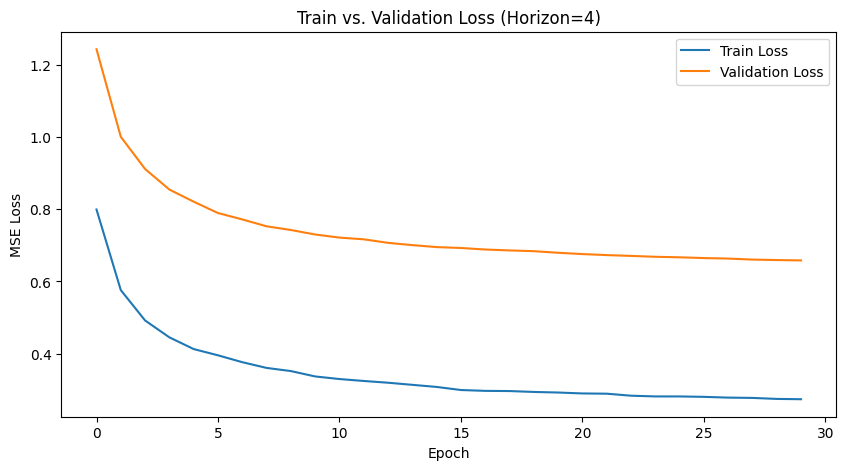

Site: site-1, Test MAE (Horizon 4): 0.6009
Site: site-10, Test MAE (Horizon 4): 0.5049
Site: site-11, Test MAE (Horizon 4): 0.7438
Site: site-12, Test MAE (Horizon 4): 0.5984
Site: site-2, Test MAE (Horizon 4): 0.7042
Site: site-3, Test MAE (Horizon 4): 0.4610
Site: site-4, Test MAE (Horizon 4): 0.4826
Site: site-5, Test MAE (Horizon 4): 0.6079
Site: site-6, Test MAE (Horizon 4): 0.5899
Site: site-7, Test MAE (Horizon 4): 0.4602
Site: site-8, Test MAE (Horizon 4): 0.4639
Site: site-9, Test MAE (Horizon 4): 0.6189

Average MAE across all sites (Horizon 4): 0.5697

Starting experiment for horizon: 8
Site: site-1 | Train: 1119 | Validation: 279 | Test: 350
Site: site-10 | Train: 1119 | Validation: 279 | Test: 350
Site: site-11 | Train: 1119 | Validation: 279 | Test: 350
Site: site-12 | Train: 1119 | Validation: 279 | Test: 350
Site: site-2 | Train: 1119 | Validation: 279 | Test: 350
Site: site-3 | Train: 1119 | Validation: 279 | Test: 350
Site: site-4 | Train: 1119 | Validation: 279 | Tes

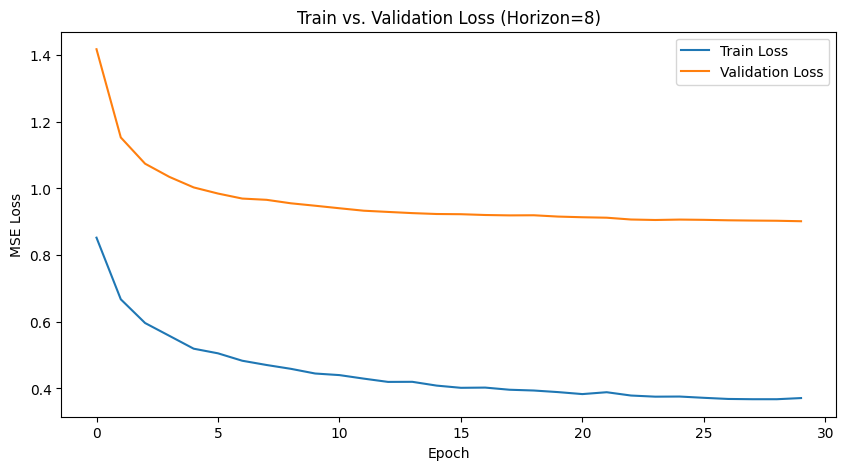

Site: site-1, Test MAE (Horizon 8): 0.6935
Site: site-10, Test MAE (Horizon 8): 0.6049
Site: site-11, Test MAE (Horizon 8): 0.8514
Site: site-12, Test MAE (Horizon 8): 0.7131
Site: site-2, Test MAE (Horizon 8): 0.8104
Site: site-3, Test MAE (Horizon 8): 0.5756
Site: site-4, Test MAE (Horizon 8): 0.6106
Site: site-5, Test MAE (Horizon 8): 0.7296
Site: site-6, Test MAE (Horizon 8): 0.6588
Site: site-7, Test MAE (Horizon 8): 0.5715
Site: site-8, Test MAE (Horizon 8): 0.5494
Site: site-9, Test MAE (Horizon 8): 0.7687

Average MAE across all sites (Horizon 8): 0.6781

Starting experiment for horizon: 16
Site: site-1 | Train: 1119 | Validation: 279 | Test: 350
Site: site-10 | Train: 1119 | Validation: 279 | Test: 350
Site: site-11 | Train: 1119 | Validation: 279 | Test: 350
Site: site-12 | Train: 1119 | Validation: 279 | Test: 350
Site: site-2 | Train: 1119 | Validation: 279 | Test: 350
Site: site-3 | Train: 1119 | Validation: 279 | Test: 350
Site: site-4 | Train: 1119 | Validation: 279 | Te

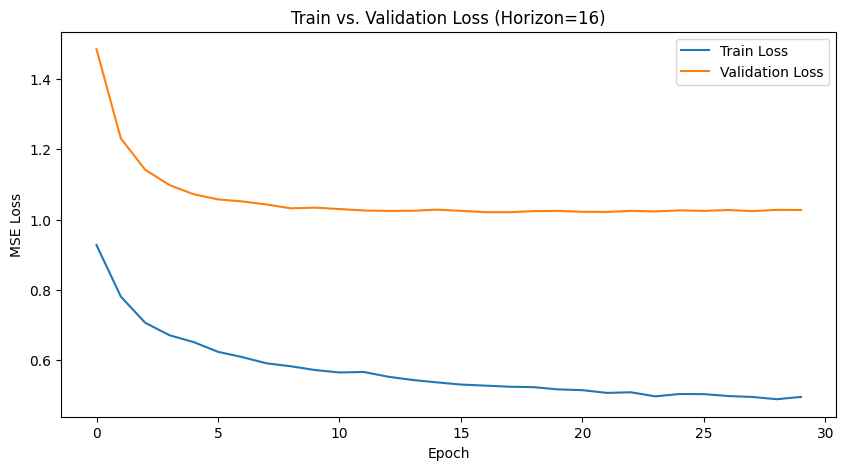

Site: site-1, Test MAE (Horizon 16): 0.7982
Site: site-10, Test MAE (Horizon 16): 0.7023
Site: site-11, Test MAE (Horizon 16): 0.9540
Site: site-12, Test MAE (Horizon 16): 0.8373
Site: site-2, Test MAE (Horizon 16): 0.9138
Site: site-3, Test MAE (Horizon 16): 0.7053
Site: site-4, Test MAE (Horizon 16): 0.7202
Site: site-5, Test MAE (Horizon 16): 0.8486
Site: site-6, Test MAE (Horizon 16): 0.7392
Site: site-7, Test MAE (Horizon 16): 0.7274
Site: site-8, Test MAE (Horizon 16): 0.6933
Site: site-9, Test MAE (Horizon 16): 0.9238

Average MAE across all sites (Horizon 16): 0.7969

Running experiments for dataset: ../processed_ds/solar/

Starting experiment for horizon: 1
Site: solar_al | Train: 1328 | Validation: 332 | Test: 415
Site: solar_fl | Train: 1328 | Validation: 332 | Test: 415
Site: solar_il | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ks | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ma | Train: 1328 | Validation: 332 | Test: 415
Site: solar_me | Train: 1328 |

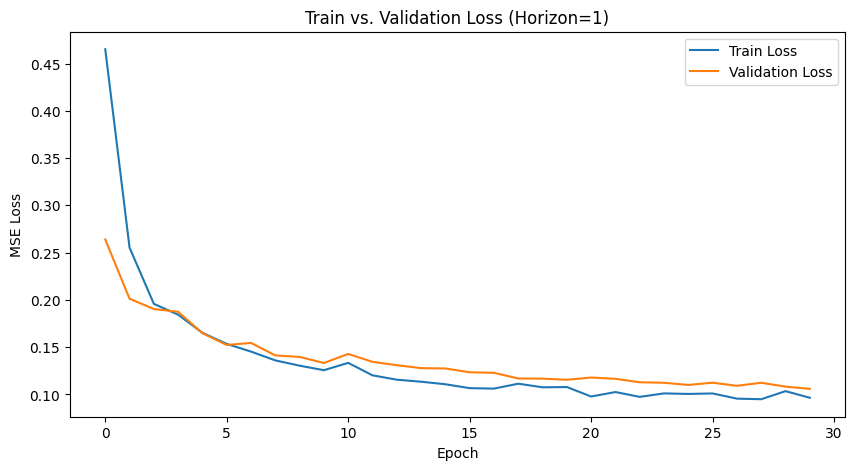

Site: solar_al, Test MAE (Horizon 1): 0.1615
Site: solar_fl, Test MAE (Horizon 1): 0.1950
Site: solar_il, Test MAE (Horizon 1): 0.1195
Site: solar_ks, Test MAE (Horizon 1): 0.1495
Site: solar_ma, Test MAE (Horizon 1): 0.2701
Site: solar_me, Test MAE (Horizon 1): 0.2352

Average MAE across all sites (Horizon 1): 0.1885

Starting experiment for horizon: 2
Site: solar_al | Train: 1328 | Validation: 332 | Test: 415
Site: solar_fl | Train: 1328 | Validation: 332 | Test: 415
Site: solar_il | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ks | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ma | Train: 1328 | Validation: 332 | Test: 415
Site: solar_me | Train: 1328 | Validation: 332 | Test: 415
data loader length: [40, 40, 40, 40, 40, 40]
max dataloader length: 40 epoch iteration: 240
Epoch 1/30 for horizon 2
Epoch 1 | Train Loss: 0.5599 | Val Loss: 0.3094
Epoch 2/30 for horizon 2
Epoch 2 | Train Loss: 0.3142 | Val Loss: 0.2498
Epoch 3/30 for horizon 2
Epoch 3 | Train Loss: 0.238

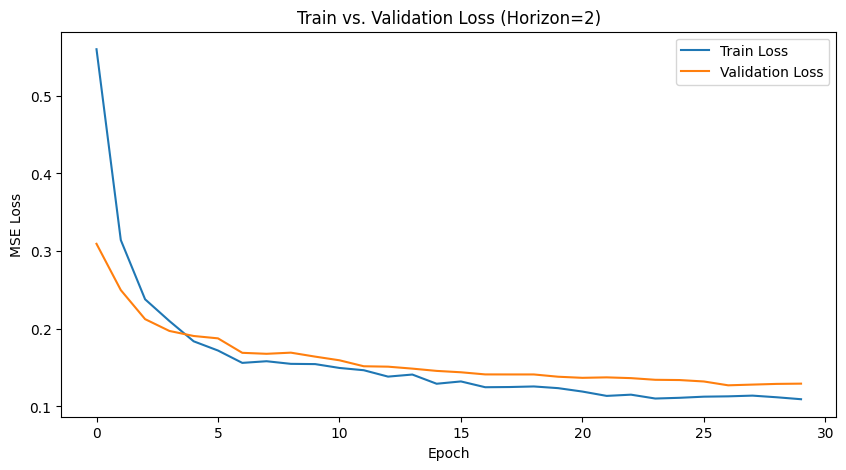

Site: solar_al, Test MAE (Horizon 2): 0.1710
Site: solar_fl, Test MAE (Horizon 2): 0.2085
Site: solar_il, Test MAE (Horizon 2): 0.1334
Site: solar_ks, Test MAE (Horizon 2): 0.1655
Site: solar_ma, Test MAE (Horizon 2): 0.2915
Site: solar_me, Test MAE (Horizon 2): 0.2478

Average MAE across all sites (Horizon 2): 0.2030

Starting experiment for horizon: 4
Site: solar_al | Train: 1328 | Validation: 332 | Test: 415
Site: solar_fl | Train: 1328 | Validation: 332 | Test: 415
Site: solar_il | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ks | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ma | Train: 1328 | Validation: 332 | Test: 415
Site: solar_me | Train: 1328 | Validation: 332 | Test: 415
data loader length: [40, 40, 40, 40, 40, 40]
max dataloader length: 40 epoch iteration: 240
Epoch 1/30 for horizon 4
Epoch 1 | Train Loss: 0.6224 | Val Loss: 0.3116
Epoch 2/30 for horizon 4
Epoch 2 | Train Loss: 0.3559 | Val Loss: 0.2756
Epoch 3/30 for horizon 4
Epoch 3 | Train Loss: 0.275

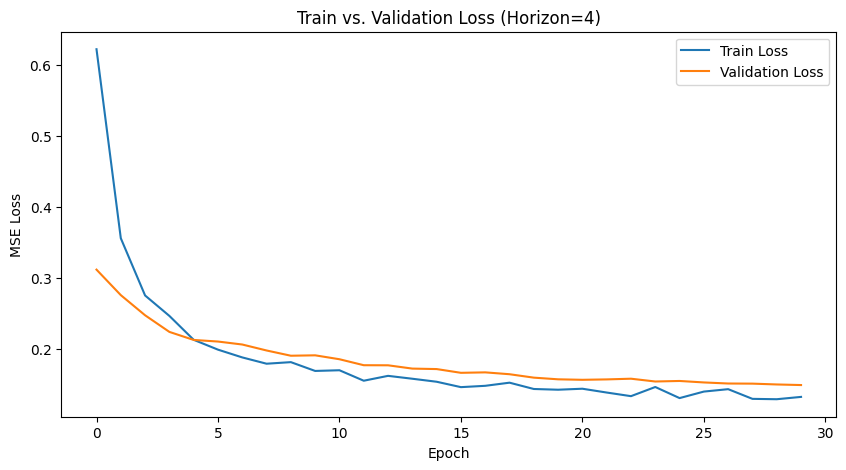

Site: solar_al, Test MAE (Horizon 4): 0.1686
Site: solar_fl, Test MAE (Horizon 4): 0.2183
Site: solar_il, Test MAE (Horizon 4): 0.1193
Site: solar_ks, Test MAE (Horizon 4): 0.1550
Site: solar_ma, Test MAE (Horizon 4): 0.3411
Site: solar_me, Test MAE (Horizon 4): 0.2414

Average MAE across all sites (Horizon 4): 0.2073

Starting experiment for horizon: 8
Site: solar_al | Train: 1328 | Validation: 332 | Test: 415
Site: solar_fl | Train: 1328 | Validation: 332 | Test: 415
Site: solar_il | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ks | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ma | Train: 1328 | Validation: 332 | Test: 415
Site: solar_me | Train: 1328 | Validation: 332 | Test: 415
data loader length: [40, 40, 40, 40, 40, 40]
max dataloader length: 40 epoch iteration: 240
Epoch 1/30 for horizon 8
Epoch 1 | Train Loss: 0.7365 | Val Loss: 0.3783
Epoch 2/30 for horizon 8
Epoch 2 | Train Loss: 0.4388 | Val Loss: 0.3340
Epoch 3/30 for horizon 8
Epoch 3 | Train Loss: 0.355

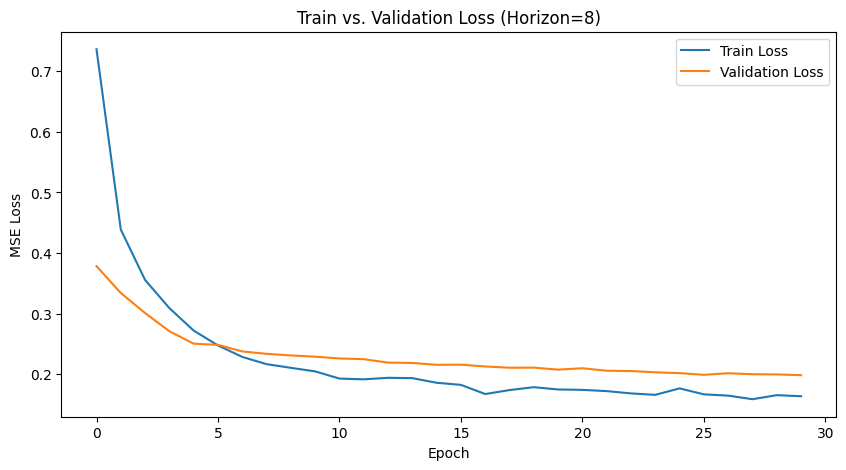

Site: solar_al, Test MAE (Horizon 8): 0.2080
Site: solar_fl, Test MAE (Horizon 8): 0.2386
Site: solar_il, Test MAE (Horizon 8): 0.1290
Site: solar_ks, Test MAE (Horizon 8): 0.1693
Site: solar_ma, Test MAE (Horizon 8): 0.3863
Site: solar_me, Test MAE (Horizon 8): 0.2531

Average MAE across all sites (Horizon 8): 0.2307

Starting experiment for horizon: 16
Site: solar_al | Train: 1328 | Validation: 332 | Test: 415
Site: solar_fl | Train: 1328 | Validation: 332 | Test: 415
Site: solar_il | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ks | Train: 1328 | Validation: 332 | Test: 415
Site: solar_ma | Train: 1328 | Validation: 332 | Test: 415
Site: solar_me | Train: 1328 | Validation: 332 | Test: 415
data loader length: [40, 40, 40, 40, 40, 40]
max dataloader length: 40 epoch iteration: 240
Epoch 1/30 for horizon 16
Epoch 1 | Train Loss: 0.7525 | Val Loss: 0.3878
Epoch 2/30 for horizon 16
Epoch 2 | Train Loss: 0.5286 | Val Loss: 0.2959
Epoch 3/30 for horizon 16
Epoch 3 | Train Loss: 0

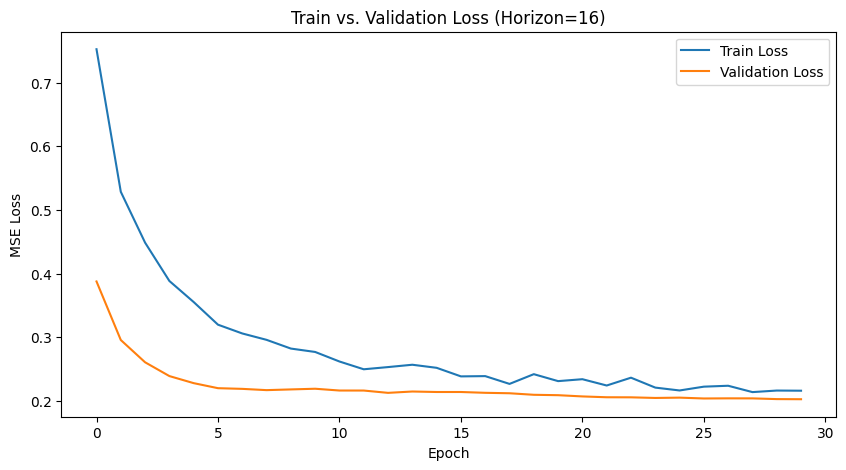

Site: solar_al, Test MAE (Horizon 16): 0.2396
Site: solar_fl, Test MAE (Horizon 16): 0.2958
Site: solar_il, Test MAE (Horizon 16): 0.1694
Site: solar_ks, Test MAE (Horizon 16): 0.2086
Site: solar_ma, Test MAE (Horizon 16): 0.4297
Site: solar_me, Test MAE (Horizon 16): 0.2755

Average MAE across all sites (Horizon 16): 0.2698

Running experiments for dataset: ../processed_ds/crypto-data/

Starting experiment for horizon: 1
Site: crypto-0 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-1 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-2 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-3 | Train: 901 | Validation: 225 | Test: 282
Site: crypto-4 | Train: 1152 | Validation: 288 | Test: 361
data loader length: [35, 35, 35, 27, 35]
max dataloader length: 35 epoch iteration: 175
Epoch 1/30 for horizon 1
Epoch 1 | Train Loss: 0.4040 | Val Loss: 0.0847
Epoch 2/30 for horizon 1
Epoch 2 | Train Loss: 0.1437 | Val Loss: 0.0725
Epoch 3/30 for horizon 1
Epoch 3 | Train Loss:

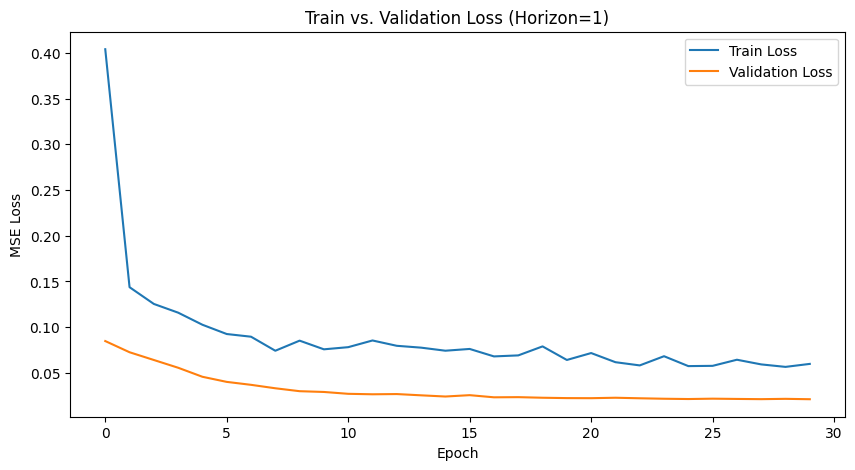

Site: crypto-0, Test MAE (Horizon 1): 0.5370
Site: crypto-1, Test MAE (Horizon 1): 0.1235
Site: crypto-2, Test MAE (Horizon 1): 0.0693
Site: crypto-3, Test MAE (Horizon 1): 0.0719
Site: crypto-4, Test MAE (Horizon 1): 0.0766

Average MAE across all sites (Horizon 1): 0.1757

Starting experiment for horizon: 2
Site: crypto-0 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-1 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-2 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-3 | Train: 901 | Validation: 225 | Test: 282
Site: crypto-4 | Train: 1152 | Validation: 288 | Test: 361
data loader length: [34, 34, 34, 27, 34]
max dataloader length: 34 epoch iteration: 170
Epoch 1/30 for horizon 2
Epoch 1 | Train Loss: 0.4212 | Val Loss: 0.0988
Epoch 2/30 for horizon 2
Epoch 2 | Train Loss: 0.1559 | Val Loss: 0.0804
Epoch 3/30 for horizon 2
Epoch 3 | Train Loss: 0.1391 | Val Loss: 0.0695
Epoch 4/30 for horizon 2
Epoch 4 | Train Loss: 0.1346 | Val Loss: 0.0613
Epoch 5/30 for 

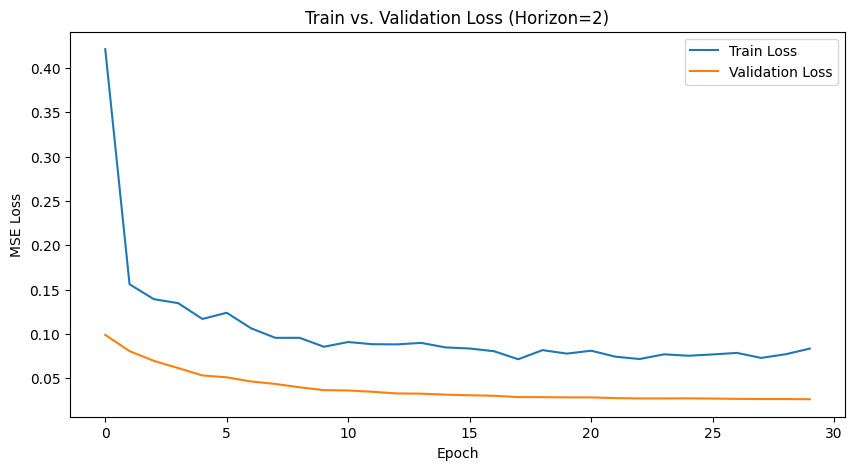

Site: crypto-0, Test MAE (Horizon 2): 0.5785
Site: crypto-1, Test MAE (Horizon 2): 0.1621
Site: crypto-2, Test MAE (Horizon 2): 0.0742
Site: crypto-3, Test MAE (Horizon 2): 0.0544
Site: crypto-4, Test MAE (Horizon 2): 0.0886

Average MAE across all sites (Horizon 2): 0.1916

Starting experiment for horizon: 4
Site: crypto-0 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-1 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-2 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-3 | Train: 901 | Validation: 225 | Test: 282
Site: crypto-4 | Train: 1152 | Validation: 288 | Test: 361
data loader length: [34, 34, 34, 27, 34]
max dataloader length: 34 epoch iteration: 170
Epoch 1/30 for horizon 4
Epoch 1 | Train Loss: 0.6474 | Val Loss: 0.2040
Epoch 2/30 for horizon 4
Epoch 2 | Train Loss: 0.2319 | Val Loss: 0.0975
Epoch 3/30 for horizon 4
Epoch 3 | Train Loss: 0.1713 | Val Loss: 0.0874
Epoch 4/30 for horizon 4
Epoch 4 | Train Loss: 0.1574 | Val Loss: 0.0832
Epoch 5/30 for 

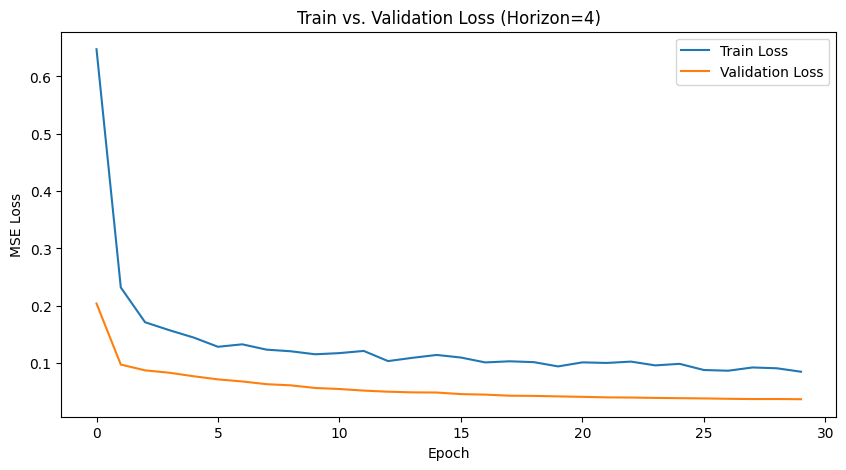

Site: crypto-0, Test MAE (Horizon 4): 0.6163
Site: crypto-1, Test MAE (Horizon 4): 0.2069
Site: crypto-2, Test MAE (Horizon 4): 0.0910
Site: crypto-3, Test MAE (Horizon 4): 0.0673
Site: crypto-4, Test MAE (Horizon 4): 0.1208

Average MAE across all sites (Horizon 4): 0.2205

Starting experiment for horizon: 8
Site: crypto-0 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-1 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-2 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-3 | Train: 901 | Validation: 225 | Test: 282
Site: crypto-4 | Train: 1152 | Validation: 288 | Test: 361
data loader length: [34, 34, 34, 26, 34]
max dataloader length: 34 epoch iteration: 170
Epoch 1/30 for horizon 8
Epoch 1 | Train Loss: 0.5840 | Val Loss: 0.2130
Epoch 2/30 for horizon 8
Epoch 2 | Train Loss: 0.2753 | Val Loss: 0.1105
Epoch 3/30 for horizon 8
Epoch 3 | Train Loss: 0.1946 | Val Loss: 0.0999
Epoch 4/30 for horizon 8
Epoch 4 | Train Loss: 0.1796 | Val Loss: 0.0936
Epoch 5/30 for 

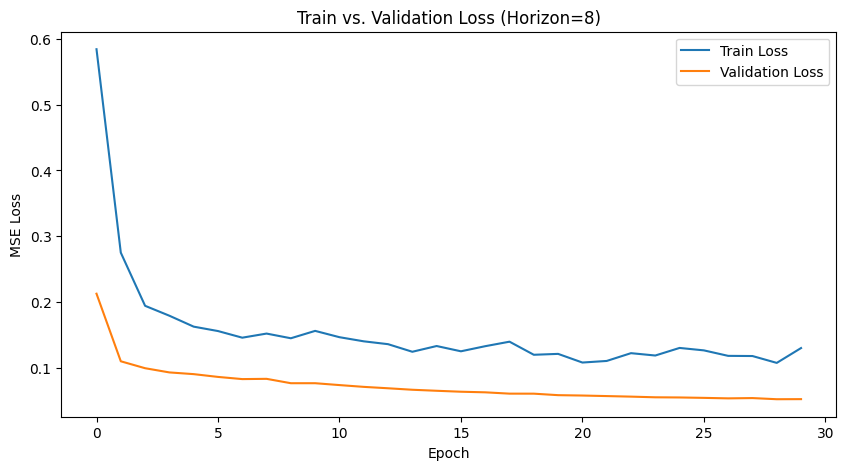

Site: crypto-0, Test MAE (Horizon 8): 0.7079
Site: crypto-1, Test MAE (Horizon 8): 0.2491
Site: crypto-2, Test MAE (Horizon 8): 0.1076
Site: crypto-3, Test MAE (Horizon 8): 0.1277
Site: crypto-4, Test MAE (Horizon 8): 0.1504

Average MAE across all sites (Horizon 8): 0.2685

Starting experiment for horizon: 16
Site: crypto-0 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-1 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-2 | Train: 1152 | Validation: 288 | Test: 361
Site: crypto-3 | Train: 901 | Validation: 225 | Test: 282
Site: crypto-4 | Train: 1152 | Validation: 288 | Test: 361
data loader length: [34, 34, 34, 26, 34]
max dataloader length: 34 epoch iteration: 170
Epoch 1/30 for horizon 16
Epoch 1 | Train Loss: 0.6979 | Val Loss: 0.3051
Epoch 2/30 for horizon 16
Epoch 2 | Train Loss: 0.3500 | Val Loss: 0.1729
Epoch 3/30 for horizon 16
Epoch 3 | Train Loss: 0.2675 | Val Loss: 0.1289
Epoch 4/30 for horizon 16
Epoch 4 | Train Loss: 0.2338 | Val Loss: 0.1246
Epoch 5/30

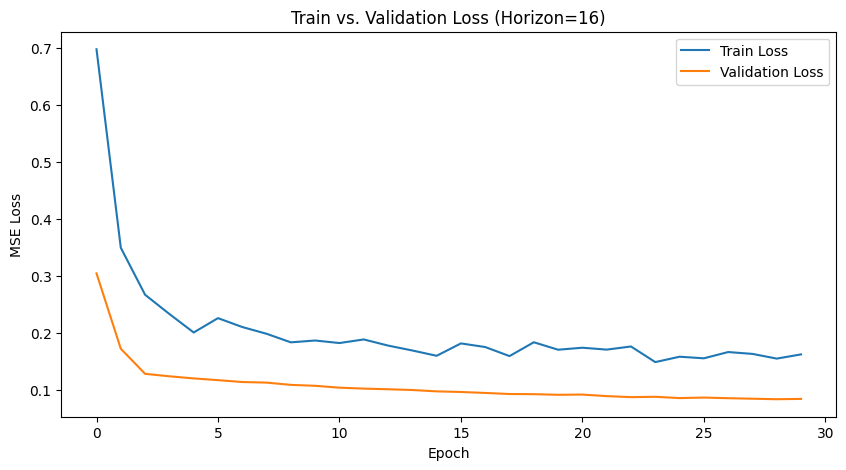

Site: crypto-0, Test MAE (Horizon 16): 0.8789
Site: crypto-1, Test MAE (Horizon 16): 0.2681
Site: crypto-2, Test MAE (Horizon 16): 0.1258
Site: crypto-3, Test MAE (Horizon 16): 0.2791
Site: crypto-4, Test MAE (Horizon 16): 0.2073

Average MAE across all sites (Horizon 16): 0.3518


In [22]:
run_global_model_experiment() # Global Model.

In [83]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

## Mackey Chaotic System Check

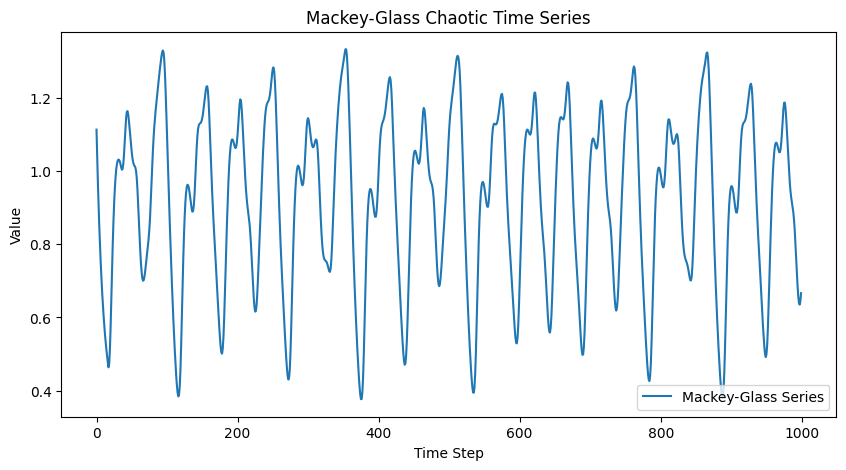

X shape: (800, 200, 1)
Y shape: (800, 1)
Epoch 1/30: Loss=0.03205040842294693
Epoch 2/30: Loss=0.032560210675001144
Epoch 3/30: Loss=0.031653955578804016
Epoch 4/30: Loss=0.030828194692730904
Epoch 5/30: Loss=0.02957787550985813
Epoch 6/30: Loss=0.028144579380750656
Epoch 7/30: Loss=0.026274532079696655
Epoch 8/30: Loss=0.023989569395780563
Epoch 9/30: Loss=0.02138347364962101
Epoch 10/30: Loss=0.018358254805207253
Epoch 11/30: Loss=0.015209161676466465
Epoch 12/30: Loss=0.012243407778441906
Epoch 13/30: Loss=0.009591113775968552
Epoch 14/30: Loss=0.0073722293600440025
Epoch 15/30: Loss=0.0056258756667375565
Epoch 16/30: Loss=0.004268671851605177
Epoch 17/30: Loss=0.003301116405054927
Epoch 18/30: Loss=0.002623463748022914
Epoch 19/30: Loss=0.002152797067537904
Epoch 20/30: Loss=0.0018227415857836604
Epoch 21/30: Loss=0.0015845857560634613
Epoch 22/30: Loss=0.0014092031633481383
Epoch 23/30: Loss=0.0012793050846084952
Epoch 24/30: Loss=0.001179124810732901
Epoch 25/30: Loss=0.001102175

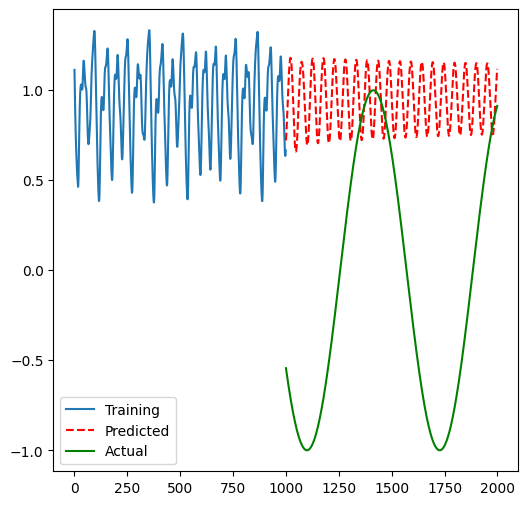

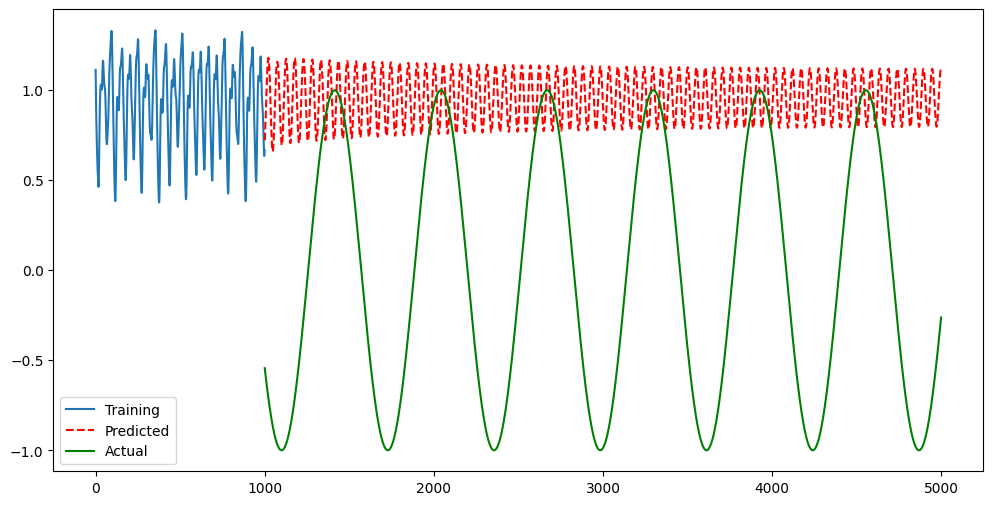

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_mackey_glass(length=1000, tau=17, dt=1.0, beta=0.2, gamma=0.1, n=10):
    """
    Generate a Mackey-Glass time series.
    
    Parameters:
        length (int): Number of time steps to generate after the initial history.
        tau (int): Delay parameter.
        dt (float): Time step size.
        beta (float): Parameter beta in the equation.
        gamma (float): Parameter gamma in the equation.
        n (float): Exponent in the denominator.
        
    Returns:
        np.ndarray: Generated Mackey-Glass time series.
    """
    # Initialize with a constant history for the first tau+1 points
    history = [1.2] * (tau + 1)
    x = list(history)
    
    # Generate the series using Euler's method
    for i in range(length):
        x_tau = x[-(tau + 1)]  # x(t - tau)
        x_new = x[-1] + dt * (beta * x_tau / (1 + x_tau ** n) - gamma * x[-1])
        x.append(x_new)
    
    # Return the series excluding the initial history
    return np.array(x[tau + 1:])

# Generate the Mackey-Glass chaotic time series
DATA_SIZE = 1000
x = generate_mackey_glass(length=DATA_SIZE, tau=17, dt=1.0, beta=0.2, gamma=0.1, n=10)

# Plot the generated Mackey-Glass series
plt.figure(figsize=(10, 5))
plt.plot(x, label="Mackey-Glass Series")
plt.title("Mackey-Glass Chaotic Time Series")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

# Create the dataset for forecasting
seq_len = 200
# Each input sequence has 'seq_len' consecutive values, reshaped to [num_samples, seq_len, 1]
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, seq_len, 1))
# The target for each sequence is the value immediately after the sequence
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, 1))

print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Training Loop
device="cuda"
EPOCHS = 30
BATCH_SIZE = 1
LEARNING_RATE = 2.2e-6
model = ForecastingModel(seq_len, embed_size=8, nhead=2, dim_feedforward=1024, dropout=0, device=device)
model.to(device)
model.train()
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)
dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
for epoch in range(EPOCHS):
    for xx, yy in dataloader:
        optimizer.zero_grad()
        out = model(xx)
        loss = criterion(out, yy)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")


# Prediction Loop
FORCAST = 1000
model.eval()
for ff in range(FORCAST):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape(1, xx.shape[0], 1).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))


# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORCAST], 'r--', label="Predicted")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10, 20, DATA_SIZE)), 'g-', label="Actual")
plt.legend()


# Prediction Loop
FORCAST_EXTENDED = 3000
model.eval()
for ff in range(FORCAST_EXTENDED):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape(1, xx.shape[0], 1).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))


# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORCAST+FORCAST_EXTENDED], 'r--', label="Predicted")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10, 50, FORCAST+FORCAST_EXTENDED)), 'g-', label="Actual")
plt.legend()


# ARIMAX

In [399]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

def run_arimax_population(site_paths, order=(1, 1, 1), min_date=None, max_date=None):
    """
    Runs an ARIMAX model for each site independently, computes forecasts
    at horizons 1, 2, 4, and 16 steps ahead, prints individual MAEs, and
    computes the average MAE across all sites for each horizon.
    
    Args:
        site_paths (list of str): List of CSV file paths for each site.
        order (tuple): The ARIMA order parameters.
    """
    horizons = [186]
    # Dictionary to store MAEs for each horizon across sites.
    all_site_mae = {h: [] for h in horizons}
    
    for csv_path in site_paths:
        print(f"\nProcessing site: {csv_path}")
        # Load and preprocess data for ARIMAX. (Assumes load_and_preprocess_site_data_arimax is defined)
        train_endog, train_exog, test_endog, test_exog = load_and_preprocess_site_data_arimax(csv_path, min_date=min_date, max_date=max_date)
        
        # Fit ARIMAX model using SARIMAX (without seasonal components)
        model = sm.tsa.statespace.SARIMAX(train_endog, exog=train_exog, order=order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        model_fit = model.fit(disp=False)
        # print(model_fit.summary())
        # Generate forecasts and compute MAE for each horizon.
        for horizon in horizons:
            # Check that there are enough rows in test_exog for the forecast horizon.
            if len(test_exog) >= horizon:
                # Forecast the next 'horizon' steps using the corresponding exogenous data.
                forecast = model_fit.forecast(steps=horizon, exog=test_exog.iloc[:horizon])
                # print("One: ", test_endog.iloc[:horizon])
                # Compute MAE over the first 'horizon' test points.
                mae_h = np.mean(np.abs(test_endog.iloc[:horizon] - forecast))
                print(f"Site: {csv_path} - Horizon {horizon} forecast MAE: {mae_h:.4f}")
                all_site_mae[horizon].append(mae_h)
                
                plt.figure(figsize=(10, 5))
                # plt.plot(train_endog)
                plt.plot(test_endog.index[:horizon], test_endog.iloc[:horizon], label='Test')
                plt.plot(test_endog.index[:horizon], forecast, label='Forecast', linestyle='--')
                plt.title(f"ARIMAX Forecast for {csv_path} at Horizon {horizon}")
                plt.xlabel("Time")
                plt.ylabel("OT")
                plt.legend()
                plt.show()
            else:
                print(f"Not enough exogenous data for horizon {horizon} at site {csv_path}.")
    
    # Compute and print the average MAE for each horizon across all sites.
    for horizon in horizons:
        if all_site_mae[horizon]:
            avg_mae = np.mean(all_site_mae[horizon])
            print(f"\nAverage MAE across all sites for horizon {horizon}: {avg_mae:.4f}")
        else:
            print(f"\nNo data to compute average MAE for horizon {horizon}")


def run_arimax_recursive(site_paths, order=(1, 1, 1), min_date=None, max_date=None):
    """
    Runs an ARIMAX model for each site independently, computes recursive forecasts
    at horizons 1, 2, 4, 8, and 16 steps ahead, prints individual MAEs, and
    computes the average MAE across all sites for each horizon.

    Args:
        site_paths (list of str): List of CSV file paths for each site.
        order (tuple): The ARIMA order parameters.
        min_date (str, optional): Minimum date filter for the dataset.
        max_date (str, optional): Maximum date filter for the dataset.
    """
    horizons = [361]
    all_site_mae = {h: [] for h in horizons}  # Store MAEs for each horizon

    for csv_path in site_paths:
        print(f"\nProcessing site: {csv_path}")

        # Load and preprocess data (Assumes function is defined)
        train_endog, train_exog, test_endog, test_exog = load_and_preprocess_site_data_arimax(csv_path, min_date=min_date, max_date=max_date)

        # Fit ARIMAX model
        model = sm.tsa.statespace.SARIMAX(train_endog, exog=train_exog, order=order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_fit = model.fit(disp=False)

        # Recursive Forecasting for Each Horizon
        predictions = []
        history = list(train_endog)  # Start with training data

        for t in range(len(test_endog)):
            if t == 0:
                # Forecast first step using test exogenous variables
                forecast = model_fit.forecast(steps=1, exog=test_exog.iloc[t:t+1])
            else:
                # Use previous predictions recursively
                forecast = model_fit.forecast(steps=1, exog=test_exog.iloc[t:t+1])

            predictions.append(forecast.values[0])
            history.append(forecast.values[0])  # Add prediction to history

        pred_series = pd.Series(predictions, index=test_endog.index)

        # Compute MAE for each horizon
        for horizon in horizons:
            if len(test_endog) >= horizon:
                mae_h = np.mean(np.abs(test_endog.iloc[:horizon] - pred_series.iloc[:horizon]))
                print(f"Site: {csv_path} - Horizon {horizon} forecast MAE: {mae_h:.4f}")
                all_site_mae[horizon].append(mae_h)

                # Plot Actual vs Forecast
                plt.figure(figsize=(10, 5))
                plt.plot(train_endog)
                plt.plot(test_endog.index[:horizon], test_endog.iloc[:horizon], label='Test', color="blue")
                plt.plot(test_endog.index[:horizon], pred_series.iloc[:horizon], label='Forecast', linestyle='--', color="red")
                plt.title(f"ARIMAX Forecast for {csv_path} at Horizon {horizon}")
                plt.xlabel("Time")
                plt.ylabel("CO Concentration")
                plt.legend()
                plt.show()
            else:
                print(f"Not enough exogenous data for horizon {horizon} at site {csv_path}.")

    # Compute and print the average MAE for each horizon across all sites
    for horizon in horizons:
        if all_site_mae[horizon]:
            avg_mae = np.mean(all_site_mae[horizon])
            print(f"\nAverage MAE across all sites for horizon {horizon}: {avg_mae:.4f}")
        else:
            print(f"\nNo data to compute average MAE for horizon {horizon}")
        


Processing site: ../processed_ds/stores_data/store-1/store-1.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-1/store-1.csv - Horizon 186 forecast MAE: 0.1194


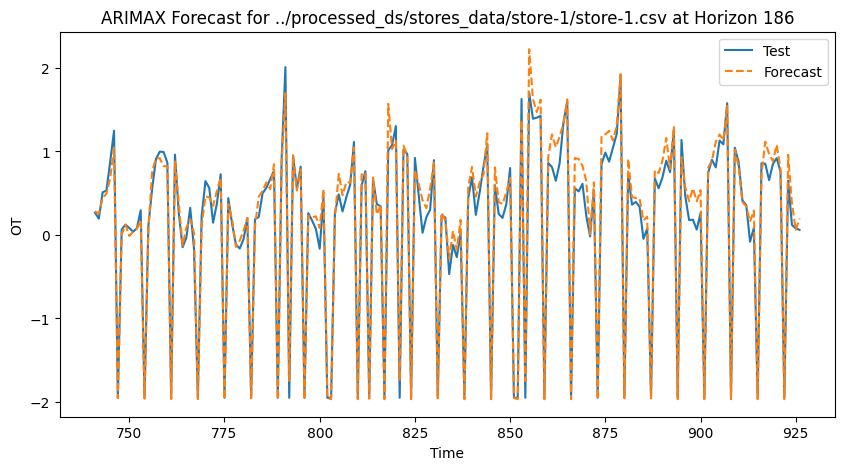


Processing site: ../processed_ds/stores_data/store-2/store-2.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-2/store-2.csv - Horizon 186 forecast MAE: 0.1534


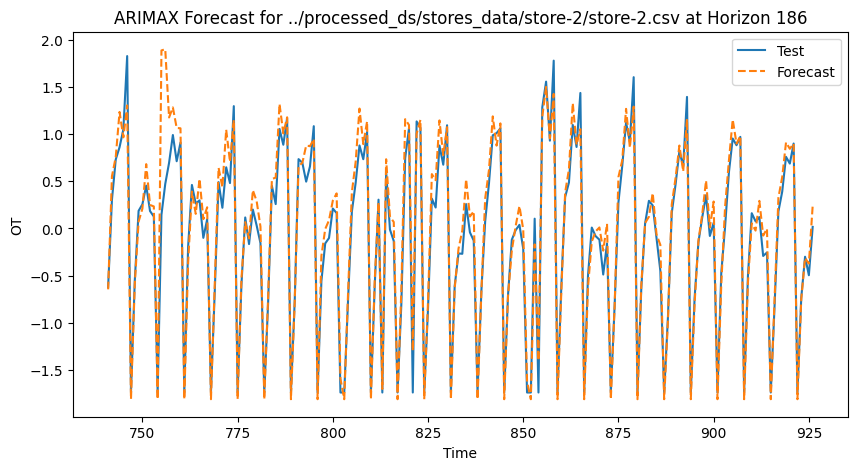


Processing site: ../processed_ds/stores_data/store-3/store-3.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-3/store-3.csv - Horizon 186 forecast MAE: 0.1170


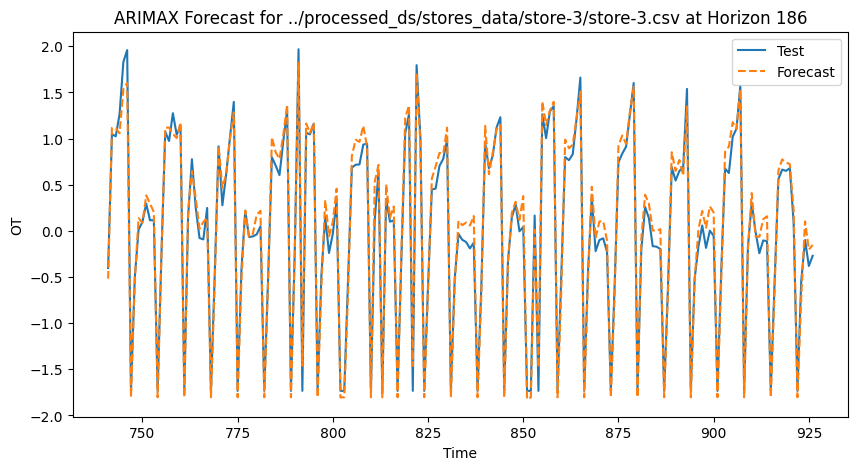


Processing site: ../processed_ds/stores_data/store-4/store-4.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-4/store-4.csv - Horizon 186 forecast MAE: 0.0856


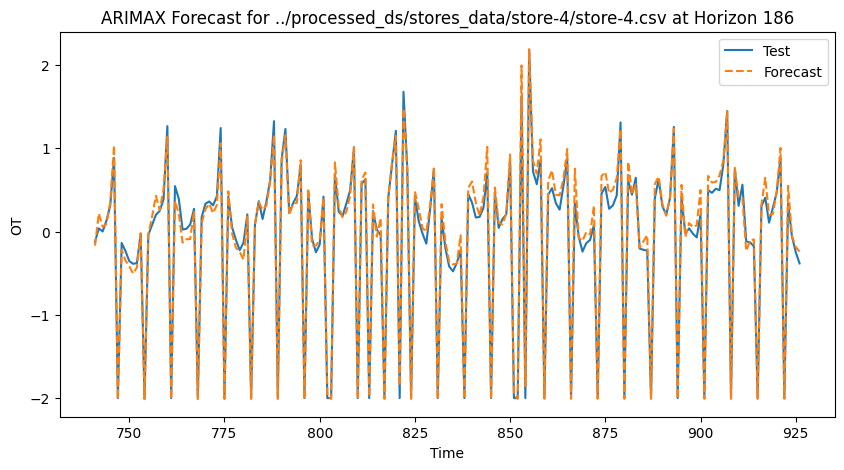


Processing site: ../processed_ds/stores_data/store-5/store-5.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-5/store-5.csv - Horizon 186 forecast MAE: 0.1522


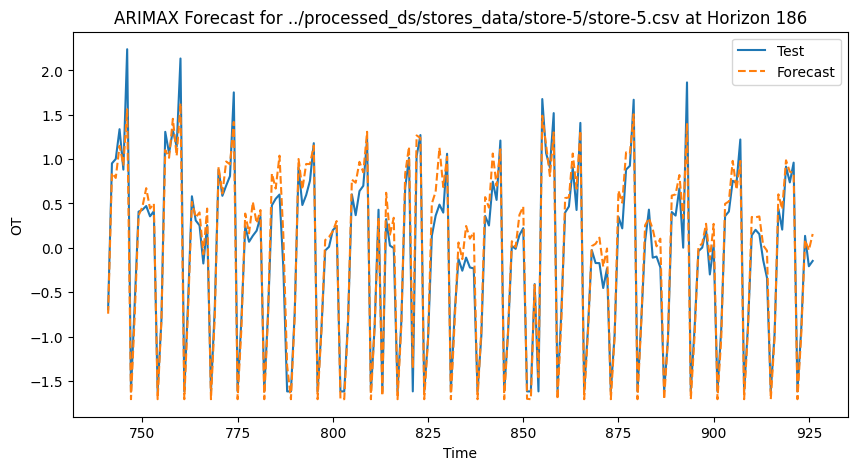


Processing site: ../processed_ds/stores_data/store-6/store-6.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-6/store-6.csv - Horizon 186 forecast MAE: 0.1083


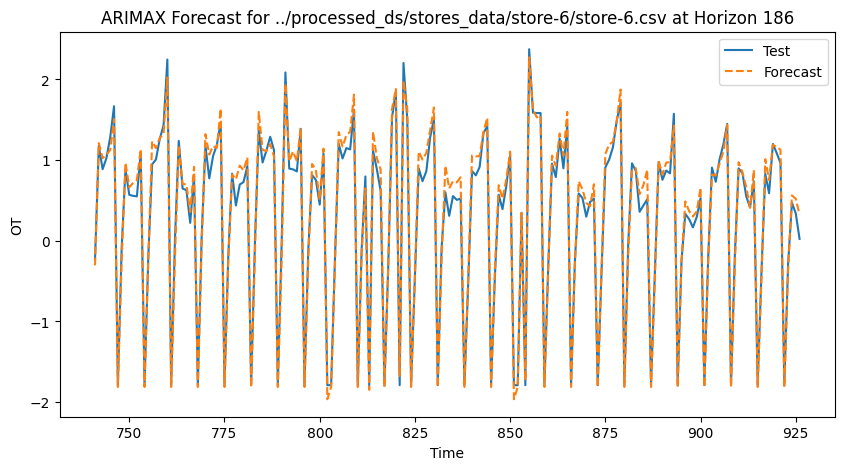


Processing site: ../processed_ds/stores_data/store-7/store-7.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-7/store-7.csv - Horizon 186 forecast MAE: 0.1263


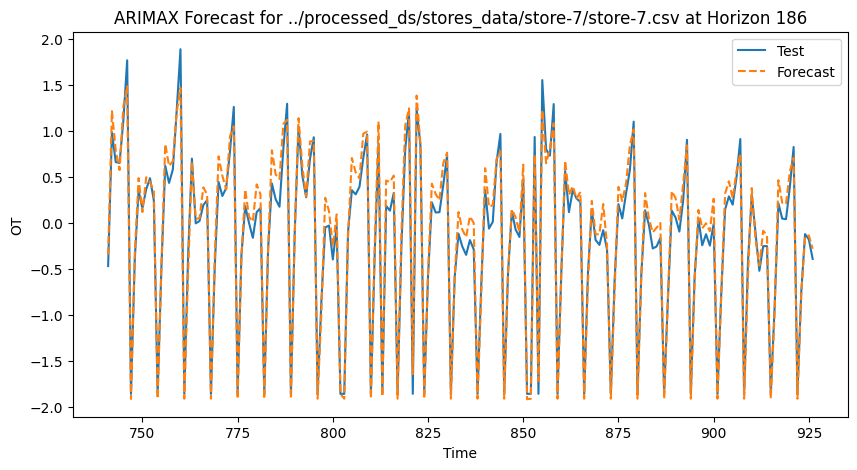


Processing site: ../processed_ds/stores_data/store-8/store-8.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-8/store-8.csv - Horizon 186 forecast MAE: 0.1185


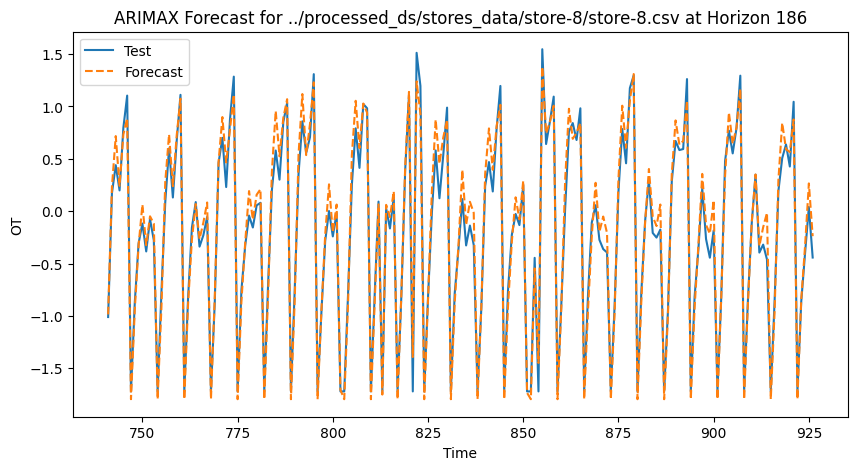


Processing site: ../processed_ds/stores_data/store-9/store-9.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-9/store-9.csv - Horizon 186 forecast MAE: 0.0764


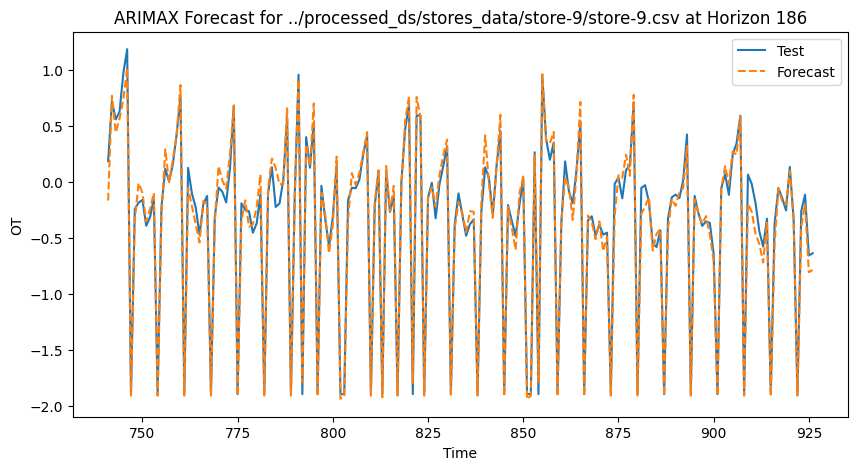


Processing site: ../processed_ds/stores_data/store-10/store-10.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-10/store-10.csv - Horizon 186 forecast MAE: 0.1254


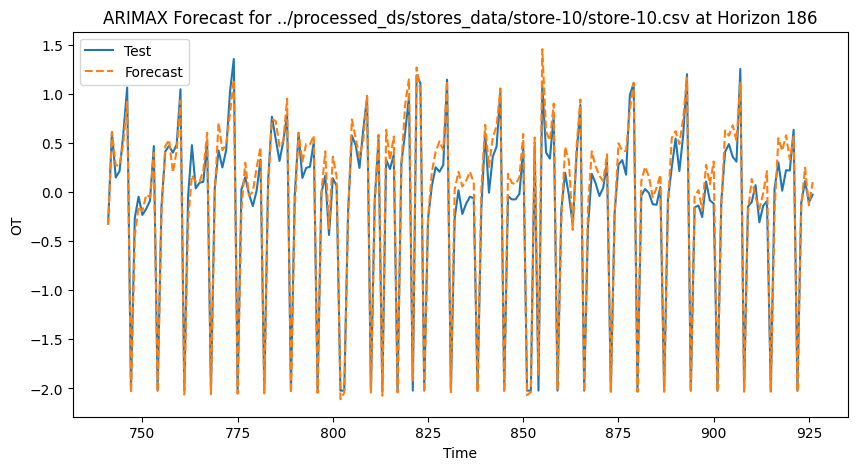


Processing site: ../processed_ds/stores_data/store-11/store-11.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-11/store-11.csv - Horizon 186 forecast MAE: 0.1268


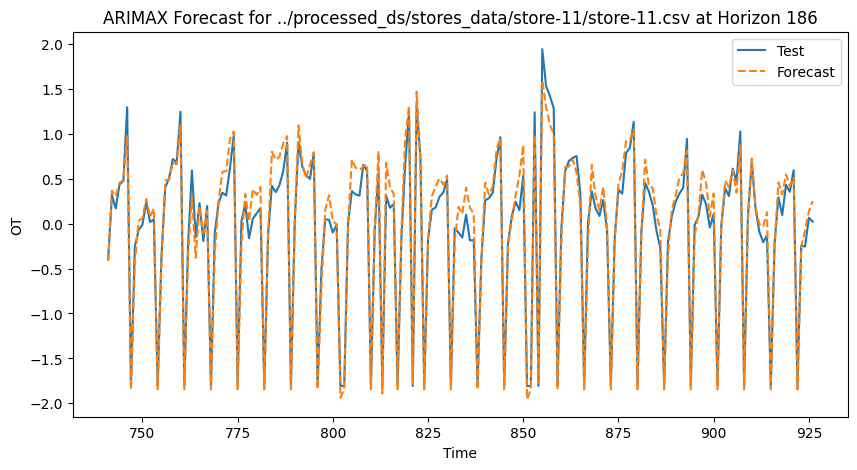


Processing site: ../processed_ds/stores_data/store-12/store-12.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-12/store-12.csv - Horizon 186 forecast MAE: 0.1023


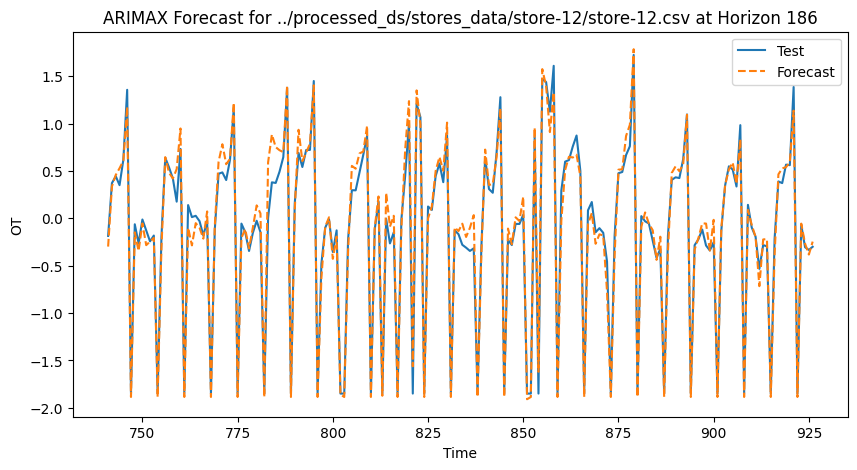


Processing site: ../processed_ds/stores_data/store-13/store-13.csv
Train size: 594 | Test size: 149
(594,) (594, 6) (149,) (149, 6)
Not enough exogenous data for horizon 186 at site ../processed_ds/stores_data/store-13/store-13.csv.

Processing site: ../processed_ds/stores_data/store-14/store-14.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-14/store-14.csv - Horizon 186 forecast MAE: 0.1097


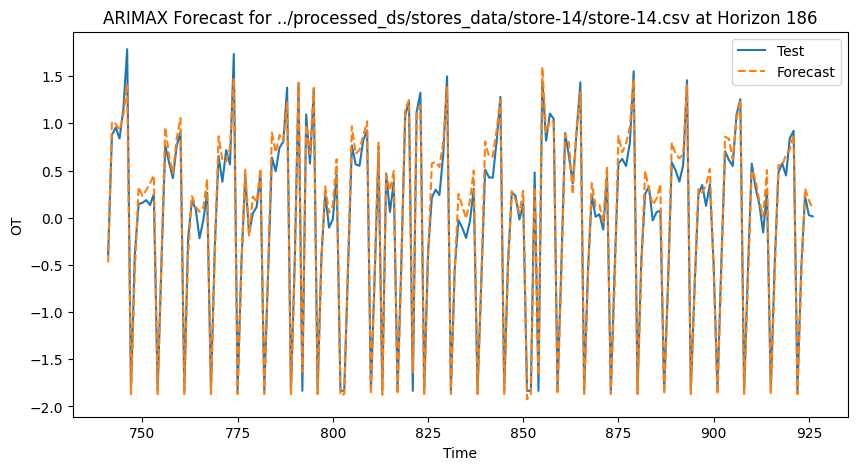


Processing site: ../processed_ds/stores_data/store-15/store-15.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-15/store-15.csv - Horizon 186 forecast MAE: 0.1009


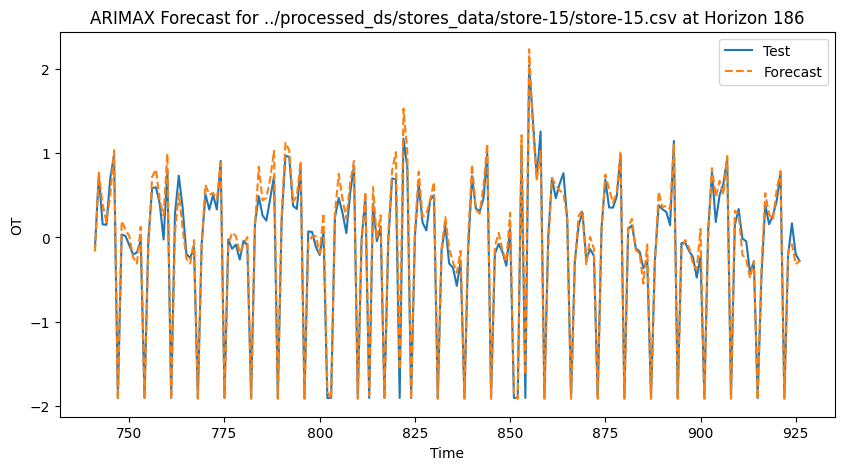


Processing site: ../processed_ds/stores_data/store-16/store-16.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-16/store-16.csv - Horizon 186 forecast MAE: 0.1467


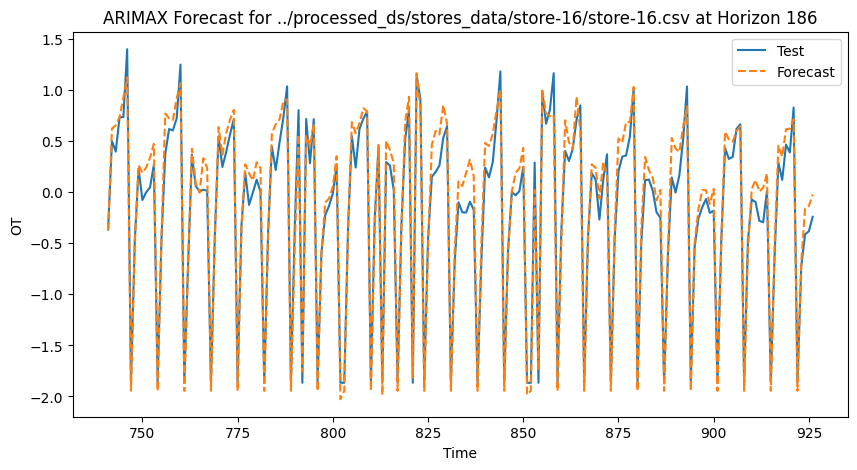


Processing site: ../processed_ds/stores_data/store-17/store-17.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-17/store-17.csv - Horizon 186 forecast MAE: 0.1391


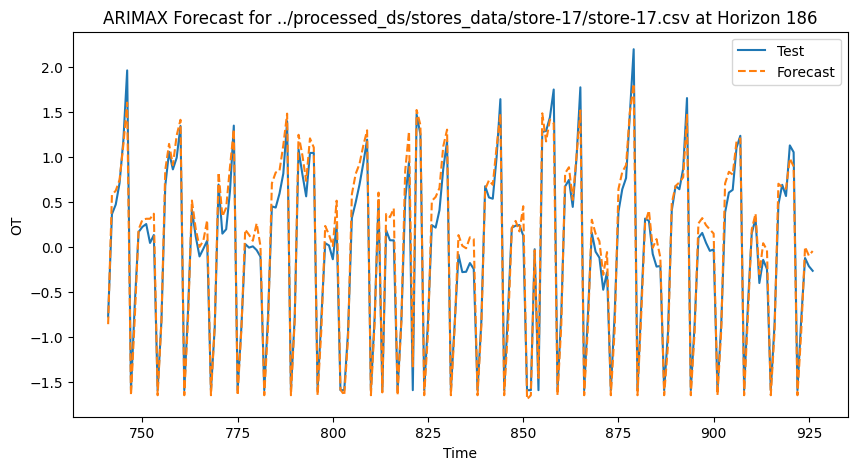


Processing site: ../processed_ds/stores_data/store-18/store-18.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-18/store-18.csv - Horizon 186 forecast MAE: 0.1383


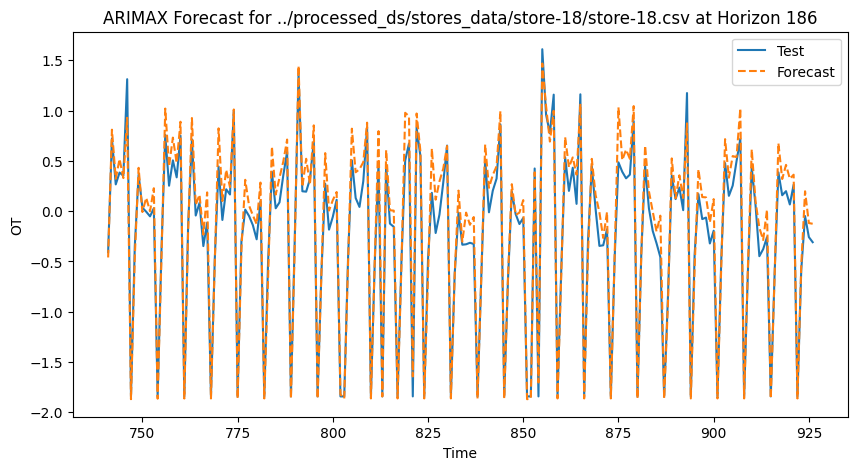


Processing site: ../processed_ds/stores_data/store-19/store-19.csv
Train size: 741 | Test size: 186
(741,) (741, 6) (186,) (186, 6)
Site: ../processed_ds/stores_data/store-19/store-19.csv - Horizon 186 forecast MAE: 0.1483


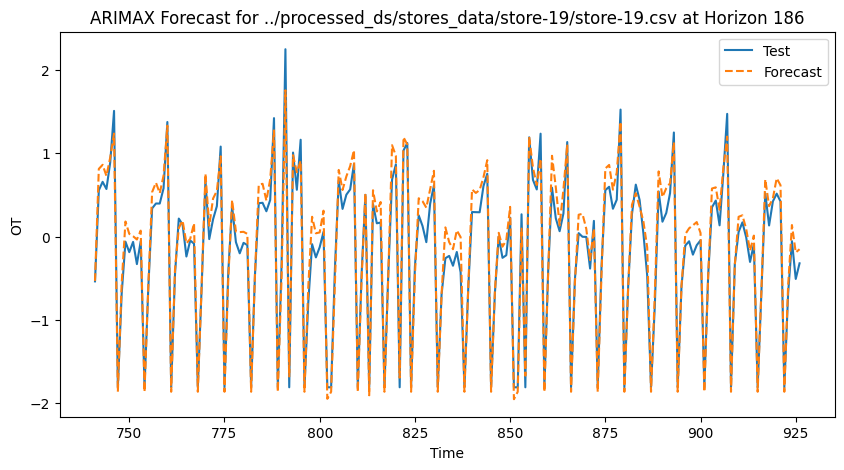


Average MAE across all sites for horizon 186: 0.1219


In [401]:
# Example usage:
# site_directory = "../processed_ds/air_quality_cluster/"
# min_date = "2014-09-01"
# max_date = "2014-11-12 19:00"
# site_paths = [f"{site_directory}site-{i}/site-{i}.csv" for i in range(1, 13)]

# site_directory = "../processed_ds/crypto-data/"
# min_date = "2018-04-01"
# max_date = "2018-06-15"
# site_paths = [f"{site_directory}crypto-{i}/crypto-{i}.csv" for i in range(0, 5)]

# site_directory = "../processed_ds/solar/"
# min_date = "2006-09-01"
# max_date = "2006-09-08 4:50"
# site_paths = [f"{site_directory}solar_{i}/solar_{i}.csv" for i in ['al', 'fl', 'il', 'ks', 'ma', 'me']]

site_directory = "../processed_ds/stores_data/"
min_date = "2013-01-16"
max_date = "2015-07-31"
site_paths = [f"{site_directory}store-{i}/store-{i}.csv" for i in range(1, 20)]

run_arimax_population(site_paths, order=(1, 0, 1), min_date=min_date, max_date=max_date)

# ARIMAX DIRECT vs Recursive

In [416]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def run_arimax_recursive_forecasting_true(site_paths, order=(1, 1, 1), min_date=None, max_date=None, horizons=[1, 2, 4, 8, 16]):
    """
    Runs ARIMAX recursive forecasting on each site using true recursion.
    After each one-step forecast, the predicted value is appended to the model's history
    and used for the next forecast step.
    
    Args:
        site_paths (list of str): List of CSV file paths for each site.
        order (tuple): ARIMA order parameters (p, d, q).
        min_date (str, optional): Minimum date filter.
        max_date (str, optional): Maximum date filter.
        horizons (list, optional): List of forecast horizons (in steps).
    """
    all_site_mae = {h: [] for h in horizons}
    
    for csv_path in site_paths:
        print(f"\nProcessing site: {csv_path}")
        # Load and preprocess data (user-defined function)
        train_endog, train_exog, test_endog, test_exog = load_and_preprocess_site_data_arimax(csv_path, min_date=min_date, max_date=max_date)
        
        # Fit the ARIMAX model on training data
        model = sm.tsa.statespace.SARIMAX(train_endog, exog=train_exog, order=order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        
        # We'll update our model recursively using its append method.
        current_model = model_fit  # Start with the fitted model from training
        predictions = []
        
        for t in range(len(test_endog)):
            # Get exogenous input for the next forecast step
            exog_input = test_exog.iloc[t:t+1].copy()
            exog_input = exog_input[train_exog.columns]
            # Forecast one step ahead using the current model state
            forecast = current_model.forecast(steps=1, exog=exog_input)
            pred_value = forecast.values[0]
            predictions.append(pred_value)
            
            # Update the model with the new "observed" value (here we use the predicted value)
            # This simulates feeding the prediction as the new observation.
            # Note: In practice, you might update with the actual observed value if available,
            # but for pure recursive forecasting we use the prediction.
            new_obs = pd.Series([pred_value], index=[test_endog.index[t]])
            print(new_obs)
            current_model = current_model.append(new_obs, exog=exog_input, refit=False)
        
        pred_series = pd.Series(predictions, index=test_endog.index)
        
        # Compute MAE for each specified horizon
        for horizon in horizons:
            if len(test_endog) >= horizon:
                mae_h = mean_absolute_error(test_endog.iloc[:horizon], pred_series.iloc[:horizon])
                print(f"Site: {csv_path} - Recursive Forecast Horizon {horizon}: MAE = {mae_h:.4f}")
                all_site_mae[horizon].append(mae_h)
                
                # Plot actual vs. forecast for the given horizon
                plt.figure(figsize=(8, 4))
                plt.plot(test_endog.index[:horizon], test_endog.iloc[:horizon], label="Actual", marker='o')
                plt.plot(test_endog.index[:horizon], pred_series.iloc[:horizon], label="Forecast", marker='x', linestyle='--')
                plt.title(f"Recursive Forecast (Horizon {horizon}) for Site: {csv_path}")
                plt.xlabel("Time")
                plt.ylabel("CO")
                plt.legend()
                plt.show()
            else:
                print(f"Not enough test data for recursive forecasting with horizon {horizon} for site {csv_path}")
    
    # Compute and print the average MAE across sites for each horizon
    for horizon in horizons:
        if all_site_mae[horizon]:
            avg_mae = np.mean(all_site_mae[horizon])
            print(f"\nAverage MAE for Recursive Forecasting at Horizon {horizon}: {avg_mae:.4f}")
        else:
            print(f"\nNo data available for Recursive Forecasting at Horizon {horizon}")

In [854]:

def run_arimax_direct_forecasting(site_paths, order=(1, 1, 1), min_date=None, max_date=None, horizons=[1, 2, 4, 8, 16]):
    """
    Runs ARIMAX direct forecasting on each site independently.
    For each forecast horizon, a separate model is trained by shifting the training target
    so that it predicts t+h directly. MAE is computed for each horizon.

    Args:
        site_paths (list of str): List of CSV file paths for each site.
        order (tuple): ARIMA order parameters (p, d, q).
        min_date (str, optional): Minimum date filter.
        max_date (str, optional): Maximum date filter.
        horizons (list, optional): List of forecast horizons (in steps).
    """
    all_site_mae = {h: [] for h in horizons}
    
    for csv_path in site_paths:
        # print(f"\nProcessing site: {csv_path}")
        # Load and preprocess data
        train_endog, train_exog, test_endog, test_exog = load_and_preprocess_site_data_arimax(csv_path, min_date=min_date, max_date=max_date)
        
        for horizon in horizons:
            # Ensure we have enough training and test data for the given horizon
            if len(train_endog) > horizon and len(test_endog) >= horizon:
                # Shift the training target by the forecast horizon.
                # At each time t, the model will learn to predict y(t+h)
                shifted_target = train_endog[horizon:].reset_index(drop=True)
                shifted_exog = train_exog[:-horizon].reset_index(drop=True)
                
                # print(shifted_target.shape, shifted_exog.shape)
                
                # Fit ARIMAX model on the shifted data
                model = sm.tsa.statespace.SARIMAX(shifted_target, exog=shifted_exog, order=order,
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
                model_fit = model.fit(disp=False)
                
                # For direct forecasting, forecast one step ahead using the exogenous data corresponding to time t+h.
                # Here we use the exogenous variables from the test set at index horizon-1.
                forecast_exog = test_exog.iloc[horizon-1:horizon]
                forecast = model_fit.forecast(steps=1, exog=forecast_exog)
                
                # Compare the forecast to the actual value at the corresponding horizon.
                actual = test_endog.iloc[horizon-1]
                mae_h = mean_absolute_error([actual], forecast)
                # print(f"Site: {csv_path} - Direct Forecast Horizon {horizon}: Actual = {actual:.4f}, Forecast = {forecast.values[0]:.4f}, MAE = {mae_h:.4f}")
                all_site_mae[horizon].append(mae_h)
                
                # Plot a simple comparison
                # plt.figure(figsize=(8, 4))
                # plt.plot([0, horizon], [actual, forecast.values[0]], marker='o', linestyle='--')
                # plt.title(f"Direct Forecast (Horizon {horizon}) for Site: {csv_path}")
                # plt.xlabel("Time Step")
                # plt.ylabel("CO")
                # plt.legend(['Actual vs Forecast'])
                # plt.show()
            else:
                print(f"Not enough data for direct forecasting with horizon {horizon} for site {csv_path}")
    
    # Average MAE across sites for each horizon
    for horizon in horizons:
        if all_site_mae[horizon]:
            avg_mae = np.mean(all_site_mae[horizon])
            print(f"\nAverage MAE for Direct Forecasting at Horizon {horizon}: {avg_mae:.4f}")
        else:
            print(f"\nNo data available for Direct Forecasting at Horizon {horizon}")
            

def run_arimax_direct_forecasting_population(base_dir,
                                               order=(1, 1, 1),
                                               min_date=None,
                                               max_date=None,
                                               horizons=[1, 2, 4, 8, 16]):
    """
    Runs ARIMAX direct forecasting in a population setting.
    
    The training data from all sites is concatenated, and for each forecast horizon,
    the training target is shifted so that the model learns to predict t+h directly.
    Then, for each site, the model forecasts one step ahead (for that horizon) using
    the corresponding exogenous data. MAE is computed per site and averaged.
    
    Args:
        base_dir (str): Directory containing site folders.
        order (tuple): ARIMA order parameters (p, d, q).
        min_date (str or datetime, optional): Minimum date filter.
        max_date (str or datetime, optional): Maximum date filter.
        horizons (list): List of forecast horizons (in steps).
    """
    # Load concatenated training data and separate test data per site.
    train_endog, train_exog, test_dict = load_all_sites_data_arimax_population(
        base_dir=base_dir, 
        target='OT', 
        features=None, 
        min_date=min_date, 
        max_date=max_date
    )
    
    # Dictionary to collect MAE values for each horizon across sites.
    all_site_mae = {h: [] for h in horizons}
    
    for horizon in horizons:
        # Make sure there is enough training data for shifting.
        if len(train_endog) <= horizon:
            print(f"Not enough training data for horizon {horizon}. Skipping.")
            continue
        
        # Shift the training data so that predictors at time t are paired with y(t+h).
        shifted_target = train_endog[horizon:].reset_index(drop=True)
        shifted_exog = train_exog[:-horizon].reset_index(drop=True)
        
        # Fit ARIMAX model on the shifted (concatenated) training data.
        model = sm.tsa.statespace.SARIMAX(shifted_target, exog=shifted_exog, order=order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        
        # Evaluate on each site's test data.
        for site, (site_test_endog, site_test_exog) in test_dict.items():
            # Ensure the site's test set has enough data.
            if len(site_test_endog) >= horizon:
                # For direct forecasting, forecast one step ahead using the exogenous data at index horizon-1.
                forecast_exog = site_test_exog.iloc[horizon-1:horizon]
                forecast = model_fit.forecast(steps=1, exog=forecast_exog)
                
                # The corresponding actual value is at index horizon-1.
                actual = site_test_endog.iloc[horizon-1]
                mae_h = mean_absolute_error([actual], forecast)
                all_site_mae[horizon].append(mae_h)
                # print(f"Site: {site} - Horizon {horizon} MAE: {mae_h:.4f}")
            else:
                print(f"Not enough test data for horizon {horizon} for site {site}")
    
    # Average MAE across sites for each horizon.
    for horizon in horizons:
        if all_site_mae[horizon]:
            avg_mae = np.mean(all_site_mae[horizon])
            print(f"\nAverage MAE for Direct Forecasting at Horizon {horizon}: {avg_mae:.4f}")
        else:
            print(f"\nNo data available for Direct Forecasting at Horizon {horizon}")

def run_arimax_direct_forecasting_population_balanced(
    base_dir,
    order=(1, 1, 1),
    min_date=None,
    max_date=None,
    horizons=[1, 2, 4, 8, 16],
    sample_size=1000  # Number of training samples to draw per site
):
    """
    Runs ARIMAX direct forecasting in a population setting with balanced training data.
    
    The training data from all sites is balanced (by sampling a fixed number from each site) and then
    concatenated into one training set. For each forecast horizon, the training target is shifted so that
    the model learns to predict t+h directly. Then, for each site, the model forecasts one step ahead using
    the corresponding exogenous data. MAE is computed per site and averaged.
    
    Args:
        base_dir (str): Directory containing site folders.
        order (tuple): ARIMA order parameters (p, d, q).
        min_date (str or datetime, optional): Minimum date filter.
        max_date (str or datetime, optional): Maximum date filter.
        horizons (list): List of forecast horizons (in steps).
        sample_size (int): Number of training samples to sample from each site.
    """
    # Load balanced training data and separate test data per site.
    train_endog, train_exog, test_dict = load_all_sites_data_arimax_concat_balanced(
        base_dir=base_dir, 
        target='OT', 
        features=None, 
        min_date=min_date, 
        max_date=max_date,
        sample_size=sample_size
    )
    
    # Dictionary to collect MAE values for each horizon across sites.
    all_site_mae = {h: [] for h in horizons}
    
    for horizon in horizons:
        if len(train_endog) <= horizon:
            print(f"Not enough training data for horizon {horizon}. Skipping.")
            continue
        
        # Shift training data so that predictors at time t are paired with y(t+h)
        shifted_target = train_endog[horizon:].reset_index(drop=True)
        shifted_exog = train_exog[:-horizon].reset_index(drop=True)
        
        # Fit ARIMAX model on the shifted (concatenated) training data.
        model = sm.tsa.statespace.SARIMAX(shifted_target, exog=shifted_exog, order=order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        
        # Evaluate on each site's test data.
        for site, (site_test_endog, site_test_exog) in test_dict.items():
            if len(site_test_endog) >= horizon:
                # For direct forecasting, forecast one step ahead using exogenous data at index horizon-1.
                forecast_exog = site_test_exog.iloc[horizon-1:horizon]
                forecast = model_fit.forecast(steps=1, exog=forecast_exog)
                
                # The corresponding actual value is at index horizon-1.
                actual = site_test_endog.iloc[horizon-1]
                mae_h = mean_absolute_error([actual], forecast)
                all_site_mae[horizon].append(mae_h)
                # print(f"Site: {site} - Horizon {horizon} MAE: {mae_h:.4f}")
            else:
                print(f"Not enough test data for horizon {horizon} for site {site}.")
    
    # Average MAE across sites for each horizon.
    for horizon in horizons:
        if all_site_mae[horizon]:
            avg_mae = np.mean(all_site_mae[horizon])
            print(f"\nAverage MAE for Direct Forecasting at Horizon {horizon}: {avg_mae:.4f}")
        else:
            print(f"\nNo data available for Direct Forecasting at Horizon {horizon}")   

In [ ]:
# Usage
site_directory = "../processed_ds/air_quality_cluster/"
min_date = "2014-09-01"
max_date = "2014-11-12 19:00"
site_paths = [f"{site_directory}site-{i}/site-{i}.csv" for i in range(1, 13)]
# site_paths = [os.path.join(site_directory, f) for f in os.listdir(site_directory) if os.path.isdir(os.path.join(site_directory, f))]

# site_directory = "../processed_ds/crypto-data/"
# min_date = "2018-04-01"
# max_date = "2018-06-15"
# site_paths = [f"{site_directory}crypto-{i}/crypto-{i}.csv" for i in range(0, 5)]

# site_directory = "../processed_ds/solar/"
# min_date = "2006-09-01"
# max_date = "2006-09-08 4:50"
# site_paths = [f"{site_directory}solar_{i}/solar_{i}.csv" for i in ['al', 'fl', 'il', 'ks', 'ma', 'me']]

# site_directory = "../processed_ds/stores_data/"
# min_date = "2013-01-16"
# max_date = "2015-07-31"
# site_paths = [f"{site_directory}store-{i}/store-{i}.csv" for i in range(1, 10)]
# run_arimax_direct_forecasting(site_paths, order=(1, 0, 1), min_date=min_date, max_date=max_date)
# run_arimax_direct_forecasting_population(site_directory, order=(1, 1, 1), min_date=min_date, max_date=max_date)
run_arimax_direct_forecasting_population_balanced(site_directory, order=(1, 1, 1), min_date=min_date, max_date=max_date, sample_size=1000)

Total Training Samples: 1200 | Number of Test Sites: 12


/home/dis-m3/Documents/Arnob/centralized-baseline/centralized/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyboardInterrupt: 